# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


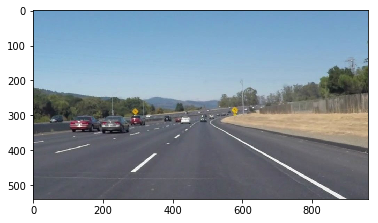

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteCurve.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [60]:
import math
from numpy.linalg import norm

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    if lines is None:
        return img
    for line in lines:
        if line is None:
            continue
        x1,y1,x2,y2 = line
        try:
            cv2.line(line_img, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)
        except:
            continue
            
    return weighted_img(line_img, img, α=1.0, β=1., λ=0.)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    lines = [line for l in lines for line in l]
    
    return lines
    

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Helper geometric functions

In [61]:
from numpy.linalg import norm
def compute_line_angle(line):
    x1, y1, x2, y2 = line
    # pointes is sorted by y
    if y1 < y2:
        x1, y1, x2, y2 = x2, y2, x1, y1
        
    return np.arctan2(y1 - y2, x2 - x1)


def compute_line_to_point_dist(line, point):
    line_point_1 = np.array([line[0], line[1]])
    line_point_2 = np.array([line[2], line[3]])
    
    return norm(np.cross(line_point_2 - line_point_1, line_point_1 - point)) / norm(line_point_2 - line_point_1)
    

def build_line_by_params(params, y_min=0, y_max=1):
    k, b = params
    x1 = int((y_min - b) / k)
    x2 = int((y_max - b) / k)
 
    return [x1, y_min, x2, y_max]


def build_line_by_points(points, y_min=0, y_max=1):
    line_params = np.polyfit([p[0] for p in points], [p[1] for p in points], 1) 
    return build_line_by_params(line_params, y_min, y_max)


def compute_line_and_point_variance(line, points):
    return np.mean([compute_line_to_point_dist(line, p) for p in points])

## K-mean for line segments

I use k-means algorithm for classify segments by included lines

In [62]:
from itertools import chain

def classify_lines_k_means(all_segments, class_count, iter_num):
    class_segments = [[] for _ in range(class_count)]
    for s in all_segments:
        class_segments[np.random.randint(class_count)].append(s)
    
    for _ in range(iter_num):
        # 1. Approximate all points in each class by on line
        class_lines = []
        for segments in class_segments:
            if not segments:
                class_lines.append(None)
                continue
            
            points = list(chain.from_iterable([[(s[0], s[1]), (s[2], s[3])] for s in segments]))
            class_lines.append(build_line_by_points(points))
           
        
        # 2. Classify all segments to nearest line from 1-st step
        class_segments = [[] for _ in range(class_count)]
        for s in all_segments:
            best_class, best_dist = None, np.inf
            for class_index, class_line in enumerate(class_lines):
                if class_line is None:
                    continue
                point_1, point_2 = (s[0], s[1]), (s[2], s[3])
                dist = compute_line_to_point_dist(class_line, point_1) + \
                       compute_line_to_point_dist(class_line, point_2)
                if dist < best_dist:
                    best_class, best_dist = class_index, dist
            
            class_segments[best_class].append(s)
        assert(sum([len(segments) for segments in class_segments]) == len(all_segments))
                          
    return class_segments
                                  

## Choice best line as road lane

In [79]:
def choice_best_line(line_groups,
                     min_angle, max_angle, max_point_variance, min_y,
                     view_center):
    best_line = None
    min_dist = np.inf
    for group in line_groups:
        if group is None or len(group) < 2:
            continue
        points = list(chain.from_iterable([[(s[0], s[1]), (s[2], s[3])] for s in group]))
        max_y = view_center[1]
        line = build_line_by_points(points, min_y, max_y)

        line_angle = compute_line_angle(line)
        if line_angle < min_angle or line_angle > max_angle:
            continue
        
        variance = compute_line_and_point_variance(line, points)
        if variance > max_point_variance:
            continue

        dist = min([norm(view_center - p) for p in points])
        if dist < min_dist:
            best_line, min_dist = line, dist
                      
    return best_line

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [80]:
import os
os.listdir("test_images/")

['solidYellowCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowLeft.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve2.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline


Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [93]:
def process_image_impl(src_image, params):
    MAX_LINE_GAP = 3
    MAX_HORISONT_FREQ = 0.35
    K_MEANS_ITER = 100
    
    left_min_angle, left_max_angle = params['min_line_angle'], params['max_line_angle']
    # Symetric
    right_min_angle, right_max_angle = np.pi - params['max_line_angle'], np.pi - params['min_line_angle']
    
    min_horisont_y = src_image.shape[0] * (1.0 - MAX_HORISONT_FREQ)
    view_center = np.array([src_image.shape[1] / 2, src_image.shape[0]])
    
    grayscale_image = grayscale(src_image)
    blured_image = gaussian_blur(grayscale_image, kernel_size=params['blur_kernel_size'])
    canny_image = canny(blured_image, params['canny_low_threshold'], params['canny_hight_threshold'])
        
    all_lines = hough_lines(canny_image,
            rho = 1,
            theta = np.pi / 720.0,
            threshold = params['hough_threshold'],
            min_line_len = params['min_line_length'],
            max_line_gap = MAX_LINE_GAP)
    
    

    # Filter by vertical position
    floor_lines = [l for l in all_lines if min(l[1], l[3]) > min_horisont_y]
    
    # Filter by angle to horisont
    left_lines = [l for l in floor_lines if left_min_angle < compute_line_angle(l) < left_max_angle]
    right_lines = [l for l in floor_lines if right_min_angle < compute_line_angle(l) < right_max_angle]

    # Filter by distance to view center
    left_lines = [l for l in left_lines if min(l[0], l[2]) < view_center[0]]
    right_lines = [l for l in right_lines if max(l[0], l[2]) > view_center[0]]
    
    # Classify classification of segments on the lines to which they include
    left_line_groups = classify_lines_k_means(left_lines, params['k_means_line_count'], K_MEANS_ITER)
    right_line_groups = classify_lines_k_means(right_lines, params['k_means_line_count'], K_MEANS_ITER)

    main_left_line = choice_best_line(left_line_groups,
                                      left_min_angle, left_max_angle, params['max_point_variance'], min_horisont_y,
                                      view_center)
    main_right_line = choice_best_line(right_line_groups,
                                       right_min_angle, right_max_angle, params['max_point_variance'], min_horisont_y,
                                       view_center)
    
    print(main_left_line, main_right_line)
    
    return draw_lines(src_image, [main_left_line, main_right_line])

test_images/solidYellowCurve.jpg
[428, 351.0, 171, 540.0] [547, 351.0, 836, 540.0]


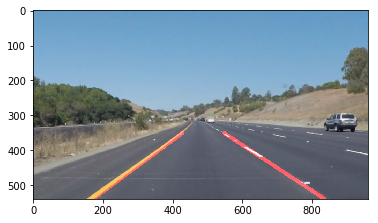

test_images/solidWhiteRight.jpg
[423, 351.0, 141, 540.0] [548, 351.0, 845, 540.0]


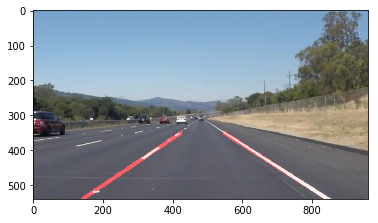

test_images/solidYellowLeft.jpg
[420, 351.0, 141, 540.0] [548, 351.0, 852, 540.0]


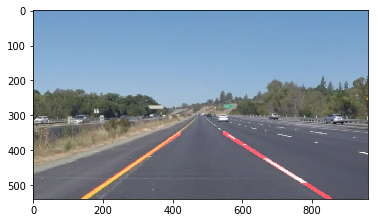

test_images/solidWhiteCurve.jpg
[431, 351.0, 178, 540.0] [551, 351.0, 885, 540.0]


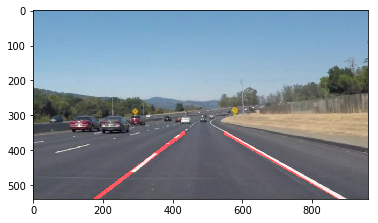

test_images/solidYellowCurve2.jpg
[420, 351.0, 163, 540.0] [551, 351.0, 861, 540.0]


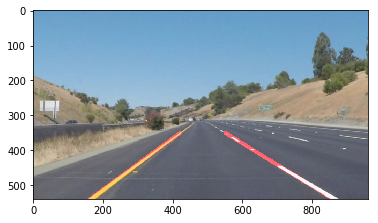

test_images/whiteCarLaneSwitch.jpg
[430, 351.0, 182, 540.0] [553, 351.0, 872, 540.0]


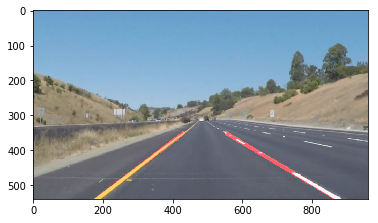

In [94]:
def process_image(src_image):
    process_params = {
        'blur_kernel_size': 9,
        'canny_low_threshold': 100,
        'canny_hight_threshold': 150,
        'hough_threshold': 4,
        'min_line_length': 10,
        'min_line_angle': np.pi / 8,
        'max_line_angle': np.pi / 2 - np.pi / 4,
        'oneline_angle_threshold': np.pi / 12,
        'oneline_dist_threshold': 2,
        'k_means_line_count': 5,
        'max_point_variance': 30.0
    }
    return process_image_impl(src_image, process_params)

IMAGES_DIR = 'test_images'
for image in os.listdir(IMAGES_DIR):
    img_path = os.path.join(IMAGES_DIR, image)
    print(img_path)
    image = mpimg.imread(img_path)
    result = process_image(image)
    plt.imshow(result)
    plt.show()

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [85]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [100]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False, threads=4)

[408, 351.0, 162, 540.0] [554, 351.0, 863, 540.0]
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4




  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 1/222 [00:00<01:23,  2.66it/s]

[408, 351.0, 162, 540.0] [554, 351.0, 863, 540.0]




  1%|          | 2/222 [00:00<01:24,  2.60it/s]

[416, 351.0, 156, 540.0] [551, 351.0, 857, 540.0]




  1%|▏         | 3/222 [00:01<01:21,  2.69it/s]

[413, 351.0, 155, 540.0] [555, 351.0, 859, 540.0]




  2%|▏         | 4/222 [00:01<01:24,  2.57it/s]

[414, 351.0, 156, 540.0] [552, 351.0, 862, 540.0]




  2%|▏         | 5/222 [00:01<01:14,  2.90it/s]

[413, 351.0, 151, 540.0] [549, 351.0, 869, 540.0]




  3%|▎         | 6/222 [00:02<01:11,  3.02it/s]

[411, 351.0, 154, 540.0] [551, 351.0, 859, 540.0]




  3%|▎         | 7/222 [00:02<01:16,  2.81it/s]

[417, 351.0, 138, 540.0] [553, 351.0, 857, 540.0]




  4%|▎         | 8/222 [00:02<01:10,  3.04it/s]

  4%|▍         | 9/222 [00:02<01:01,  3.48it/s]

[422, 351.0, 123, 540.0] [554, 351.0, 863, 540.0]
[422, 351.0, 134, 540.0] [550, 351.0, 864, 540.0]




  5%|▍         | 10/222 [00:03<00:58,  3.61it/s]

[415, 351.0, 153, 540.0] [542, 351.0, 867, 540.0]




  5%|▍         | 11/222 [00:03<00:58,  3.60it/s]

[421, 351.0, 152, 540.0] [548, 351.0, 848, 540.0]




  5%|▌         | 12/222 [00:03<01:04,  3.27it/s]

[420, 351.0, 160, 540.0] [548, 351.0, 850, 540.0]




  6%|▌         | 13/222 [00:04<01:04,  3.23it/s]

[419, 351.0, 154, 540.0] [542, 351.0, 850, 540.0]




  6%|▋         | 14/222 [00:04<01:08,  3.02it/s]

[415, 351.0, 148, 540.0] [541, 351.0, 852, 540.0]




  7%|▋         | 15/222 [00:05<01:17,  2.69it/s]

[412, 351.0, 152, 540.0] [550, 351.0, 842, 540.0]




  7%|▋         | 16/222 [00:05<01:15,  2.72it/s]

  8%|▊         | 17/222 [00:05<01:04,  3.19it/s]

[411, 351.0, 145, 540.0] [557, 351.0, 846, 540.0]
[409, 351.0, 143, 540.0] [554, 351.0, 847, 540.0]




  8%|▊         | 18/222 [00:05<01:01,  3.32it/s]

  9%|▊         | 19/222 [00:06<00:53,  3.82it/s]

[416, 351.0, 124, 540.0] [559, 351.0, 840, 540.0]
[420, 351.0, 121, 540.0] [551, 351.0, 849, 540.0]




  9%|▉         | 20/222 [00:06<00:50,  4.02it/s]

[419, 351.0, 138, 540.0] [548, 351.0, 850, 540.0]




  9%|▉         | 21/222 [00:06<00:47,  4.21it/s]

[433, 351.0, 119, 540.0] [554, 351.0, 848, 540.0]




 10%|▉         | 22/222 [00:06<00:52,  3.81it/s]

[420, 351.0, 146, 540.0] [551, 351.0, 847, 540.0]




 10%|█         | 23/222 [00:07<00:56,  3.52it/s]

[417, 351.0, 149, 540.0] [555, 351.0, 844, 540.0]




 11%|█         | 24/222 [00:07<00:56,  3.53it/s]

[414, 351.0, 150, 540.0] [552, 351.0, 842, 540.0]




 11%|█▏        | 25/222 [00:07<01:02,  3.14it/s]

[414, 351.0, 151, 540.0] [557, 351.0, 847, 540.0]




 12%|█▏        | 26/222 [00:08<01:08,  2.85it/s]

[413, 351.0, 146, 540.0] [546, 351.0, 851, 540.0]




 12%|█▏        | 27/222 [00:08<01:06,  2.93it/s]

[417, 351.0, 149, 540.0] [552, 351.0, 850, 540.0]




 13%|█▎        | 28/222 [00:08<01:01,  3.15it/s]

 13%|█▎        | 29/222 [00:08<00:52,  3.65it/s]

[418, 351.0, 146, 540.0] [548, 351.0, 836, 540.0]
[419, 351.0, 151, 540.0] [553, 351.0, 849, 540.0]




 14%|█▎        | 30/222 [00:09<00:52,  3.64it/s]

[421, 351.0, 129, 540.0] [552, 351.0, 848, 540.0]




 14%|█▍        | 31/222 [00:09<00:54,  3.50it/s]

[422, 351.0, 130, 540.0] [551, 351.0, 854, 540.0]




 14%|█▍        | 32/222 [00:09<00:49,  3.85it/s]

[420, 351.0, 134, 540.0] [553, 351.0, 852, 540.0]




 15%|█▍        | 33/222 [00:09<00:45,  4.11it/s]

[413, 351.0, 148, 540.0] [559, 351.0, 854, 540.0]




 15%|█▌        | 34/222 [00:10<00:48,  3.84it/s]

[419, 351.0, 151, 540.0] [554, 351.0, 851, 540.0]




 16%|█▌        | 35/222 [00:10<00:51,  3.64it/s]

[414, 351.0, 156, 540.0] [552, 351.0, 849, 540.0]




 16%|█▌        | 36/222 [00:10<00:57,  3.24it/s]

[421, 351.0, 148, 540.0] [547, 351.0, 845, 540.0]




 17%|█▋        | 37/222 [00:11<00:56,  3.26it/s]

[419, 351.0, 153, 540.0] [546, 351.0, 847, 540.0]




 17%|█▋        | 38/222 [00:11<01:00,  3.04it/s]

[418, 351.0, 158, 540.0] [546, 351.0, 849, 540.0]




 18%|█▊        | 39/222 [00:11<01:00,  3.03it/s]

[420, 351.0, 155, 540.0] [548, 351.0, 848, 540.0]




 18%|█▊        | 40/222 [00:12<01:05,  2.76it/s]

[416, 351.0, 151, 540.0] [549, 351.0, 844, 540.0]




 18%|█▊        | 41/222 [00:12<00:59,  3.06it/s]

[415, 351.0, 150, 540.0] [554, 351.0, 849, 540.0]




 19%|█▉        | 42/222 [00:12<00:53,  3.33it/s]

[420, 351.0, 125, 540.0] [551, 351.0, 849, 540.0]




 19%|█▉        | 43/222 [00:13<01:00,  2.97it/s]

[415, 351.0, 140, 540.0] [553, 351.0, 846, 540.0]




 20%|█▉        | 44/222 [00:13<00:53,  3.35it/s]

[416, 351.0, 133, 540.0] [555, 351.0, 845, 540.0]




 20%|██        | 45/222 [00:13<00:48,  3.65it/s]

[416, 351.0, 135, 540.0] [558, 351.0, 848, 540.0]




 21%|██        | 46/222 [00:13<00:46,  3.76it/s]

[419, 351.0, 134, 540.0] [556, 351.0, 856, 540.0]




 21%|██        | 47/222 [00:14<00:44,  3.97it/s]

[415, 351.0, 144, 540.0] [556, 351.0, 851, 540.0]




 22%|██▏       | 48/222 [00:14<00:45,  3.84it/s]

[410, 351.0, 151, 540.0] [550, 351.0, 845, 540.0]




 22%|██▏       | 49/222 [00:14<00:50,  3.45it/s]

[413, 351.0, 140, 540.0] [547, 351.0, 850, 540.0]




 23%|██▎       | 50/222 [00:15<01:01,  2.82it/s]

[411, 351.0, 159, 540.0] [557, 351.0, 840, 540.0]




 23%|██▎       | 51/222 [00:15<00:57,  2.95it/s]

[409, 351.0, 149, 540.0] [525, 351.0, 854, 540.0]




 23%|██▎       | 52/222 [00:15<00:55,  3.06it/s]

[410, 351.0, 144, 540.0] [550, 351.0, 842, 540.0]




 24%|██▍       | 53/222 [00:16<00:49,  3.43it/s]

[412, 351.0, 136, 540.0] [548, 351.0, 854, 540.0]




 24%|██▍       | 54/222 [00:16<00:53,  3.15it/s]

 25%|██▍       | 55/222 [00:16<00:46,  3.60it/s]

[414, 351.0, 108, 540.0] [552, 351.0, 842, 540.0]
[415, 351.0, 118, 540.0] [552, 351.0, 854, 540.0]




 25%|██▌       | 56/222 [00:17<00:46,  3.54it/s]

 26%|██▌       | 57/222 [00:17<00:41,  3.94it/s]

[409, 351.0, 147, 540.0] [555, 351.0, 848, 540.0]
[420, 351.0, 124, 540.0] [550, 351.0, 844, 540.0]




 26%|██▌       | 58/222 [00:17<00:44,  3.67it/s]

[418, 351.0, 136, 540.0] [550, 351.0, 846, 540.0]




 27%|██▋       | 59/222 [00:17<00:42,  3.82it/s]

[413, 351.0, 141, 540.0] [542, 351.0, 850, 540.0]




 27%|██▋       | 60/222 [00:18<00:43,  3.71it/s]

[414, 351.0, 135, 540.0] [549, 351.0, 842, 540.0]




 27%|██▋       | 61/222 [00:18<00:45,  3.52it/s]

[414, 351.0, 137, 540.0] [541, 351.0, 833, 540.0]




 28%|██▊       | 62/222 [00:18<00:53,  2.99it/s]

[414, 351.0, 137, 540.0] [549, 351.0, 839, 540.0]




 28%|██▊       | 63/222 [00:19<00:55,  2.85it/s]

[411, 351.0, 136, 540.0] [548, 351.0, 840, 540.0]




 29%|██▉       | 64/222 [00:19<00:50,  3.14it/s]

[414, 351.0, 133, 540.0] [538, 351.0, 837, 540.0]




 29%|██▉       | 65/222 [00:19<00:50,  3.08it/s]

[412, 351.0, 138, 540.0] [544, 351.0, 839, 540.0]




 30%|██▉       | 66/222 [00:20<00:49,  3.16it/s]

 30%|███       | 67/222 [00:20<00:42,  3.63it/s]

[432, 351.0, 36, 540.0] [549, 351.0, 839, 540.0]
[418, 351.0, 94, 540.0] [547, 351.0, 840, 540.0]




 31%|███       | 68/222 [00:20<00:42,  3.64it/s]

[414, 351.0, 116, 540.0] [549, 351.0, 846, 540.0]




 31%|███       | 69/222 [00:20<00:42,  3.59it/s]

 32%|███▏      | 70/222 [00:21<00:37,  4.02it/s]

[416, 351.0, 116, 540.0] [547, 351.0, 836, 540.0]
[416, 351.0, 117, 540.0] [544, 351.0, 831, 540.0]




 32%|███▏      | 71/222 [00:21<00:38,  3.97it/s]

[414, 351.0, 124, 540.0] [546, 351.0, 840, 540.0]




 32%|███▏      | 72/222 [00:21<00:39,  3.77it/s]

[409, 351.0, 125, 540.0] [557, 351.0, 834, 540.0]




 33%|███▎      | 73/222 [00:21<00:42,  3.51it/s]

[410, 351.0, 129, 540.0] [548, 351.0, 836, 540.0]




 33%|███▎      | 74/222 [00:22<00:42,  3.47it/s]

[412, 351.0, 129, 540.0] [542, 351.0, 835, 540.0]




 34%|███▍      | 75/222 [00:22<00:47,  3.12it/s]

[413, 351.0, 126, 540.0] [542, 351.0, 837, 540.0]




 34%|███▍      | 76/222 [00:22<00:46,  3.14it/s]

[410, 351.0, 123, 540.0] [546, 351.0, 832, 540.0]




 35%|███▍      | 77/222 [00:23<00:44,  3.25it/s]

 35%|███▌      | 78/222 [00:23<00:38,  3.78it/s]

[408, 351.0, 127, 540.0] [553, 351.0, 831, 540.0]
[412, 351.0, 101, 540.0] [525, 351.0, 841, 540.0]




 36%|███▌      | 79/222 [00:23<00:34,  4.17it/s]

[411, 351.0, 114, 540.0] [548, 351.0, 828, 540.0]




 36%|███▌      | 80/222 [00:23<00:35,  4.00it/s]

 36%|███▋      | 81/222 [00:23<00:31,  4.44it/s]

[411, 351.0, 109, 540.0] [547, 351.0, 835, 540.0]
[424, 351.0, 78, 540.0] [546, 351.0, 826, 540.0]




 37%|███▋      | 82/222 [00:24<00:31,  4.45it/s]

[416, 351.0, 100, 540.0] [541, 351.0, 831, 540.0]




 37%|███▋      | 83/222 [00:24<00:31,  4.41it/s]

[406, 351.0, 126, 540.0] [542, 351.0, 823, 540.0]




 38%|███▊      | 84/222 [00:24<00:38,  3.63it/s]

[408, 351.0, 118, 540.0] [546, 351.0, 819, 540.0]




 38%|███▊      | 85/222 [00:25<00:39,  3.43it/s]

[410, 351.0, 123, 540.0] [543, 351.0, 828, 540.0]




 39%|███▊      | 86/222 [00:25<00:40,  3.38it/s]

[408, 351.0, 122, 540.0] [548, 351.0, 834, 540.0]




 39%|███▉      | 87/222 [00:25<00:42,  3.18it/s]

[410, 351.0, 118, 540.0] [544, 351.0, 825, 540.0]




 40%|███▉      | 88/222 [00:26<00:40,  3.27it/s]

[411, 351.0, 124, 540.0] [543, 351.0, 829, 540.0]




 40%|████      | 89/222 [00:26<00:42,  3.10it/s]

[411, 351.0, 125, 540.0] [541, 351.0, 818, 540.0]




 41%|████      | 90/222 [00:26<00:40,  3.28it/s]

[414, 351.0, 109, 540.0] [544, 351.0, 824, 540.0]




 41%|████      | 91/222 [00:26<00:37,  3.46it/s]

[418, 351.0, 114, 540.0] [538, 351.0, 819, 540.0]




 41%|████▏     | 92/222 [00:27<00:37,  3.47it/s]

[416, 351.0, 120, 540.0] [548, 351.0, 828, 540.0]
[417, 351.0, 116, 540.0] [547, 351.0, 831, 540.0]




 42%|████▏     | 93/222 [00:27<00:33,  3.83it/s]

 42%|████▏     | 94/222 [00:27<00:32,  3.88it/s]

[418, 351.0, 114, 540.0] [554, 351.0, 814, 540.0]




 43%|████▎     | 95/222 [00:27<00:33,  3.74it/s]

[410, 351.0, 128, 540.0] [542, 351.0, 825, 540.0]




 43%|████▎     | 96/222 [00:28<00:35,  3.55it/s]

[409, 351.0, 121, 540.0] [554, 351.0, 820, 540.0]




 44%|████▎     | 97/222 [00:28<00:35,  3.51it/s]

[412, 351.0, 127, 540.0] [543, 351.0, 826, 540.0]




 44%|████▍     | 98/222 [00:28<00:39,  3.16it/s]

[409, 351.0, 124, 540.0] [548, 351.0, 822, 540.0]




 45%|████▍     | 99/222 [00:29<00:38,  3.21it/s]

[413, 351.0, 124, 540.0] [555, 351.0, 828, 540.0]




 45%|████▌     | 100/222 [00:29<00:37,  3.29it/s]

[414, 351.0, 121, 540.0] [550, 351.0, 829, 540.0]




 45%|████▌     | 101/222 [00:29<00:35,  3.40it/s]

 46%|████▌     | 102/222 [00:30<00:31,  3.80it/s]

[413, 351.0, 123, 540.0] [555, 351.0, 826, 540.0]
[423, 351.0, 80, 540.0] [550, 351.0, 821, 540.0]




 46%|████▋     | 103/222 [00:30<00:29,  3.98it/s]

 47%|████▋     | 104/222 [00:30<00:27,  4.34it/s]

[425, 351.0, 93, 540.0] [546, 351.0, 827, 540.0]
[422, 351.0, 121, 540.0] [555, 351.0, 828, 540.0]




 47%|████▋     | 105/222 [00:30<00:31,  3.76it/s]

[424, 351.0, 117, 540.0] [552, 351.0, 823, 540.0]




 48%|████▊     | 106/222 [00:31<00:33,  3.42it/s]

[423, 351.0, 123, 540.0] [550, 351.0, 832, 540.0]




 48%|████▊     | 107/222 [00:31<00:32,  3.56it/s]

[417, 351.0, 137, 540.0] [548, 351.0, 833, 540.0]




 49%|████▊     | 108/222 [00:31<00:33,  3.37it/s]

[409, 351.0, 143, 540.0] [549, 351.0, 830, 540.0]




 49%|████▉     | 109/222 [00:32<00:35,  3.23it/s]

[412, 351.0, 142, 540.0] [552, 351.0, 830, 540.0]




 50%|████▉     | 110/222 [00:32<00:35,  3.11it/s]

[416, 351.0, 141, 540.0] [552, 351.0, 834, 540.0]




 50%|█████     | 111/222 [00:32<00:37,  3.00it/s]

[414, 351.0, 144, 540.0] [552, 351.0, 833, 540.0]




 50%|█████     | 112/222 [00:33<00:37,  2.90it/s]

[414, 351.0, 139, 540.0] [556, 351.0, 836, 540.0]




 51%|█████     | 113/222 [00:33<00:37,  2.93it/s]

[414, 351.0, 142, 540.0] [556, 351.0, 836, 540.0]




 51%|█████▏    | 114/222 [00:33<00:39,  2.71it/s]

[418, 351.0, 125, 540.0] [555, 351.0, 837, 540.0]




 52%|█████▏    | 115/222 [00:34<00:39,  2.74it/s]

[412, 351.0, 138, 540.0] [557, 351.0, 831, 540.0]




 52%|█████▏    | 116/222 [00:34<00:44,  2.38it/s]

[416, 351.0, 113, 540.0] [553, 351.0, 842, 540.0]




 53%|█████▎    | 117/222 [00:35<00:41,  2.54it/s]

[416, 351.0, 127, 540.0] [552, 351.0, 835, 540.0]




 53%|█████▎    | 118/222 [00:35<00:37,  2.77it/s]

[418, 351.0, 119, 540.0] [555, 351.0, 835, 540.0]




 54%|█████▎    | 119/222 [00:35<00:36,  2.85it/s]

[417, 351.0, 121, 540.0] [551, 351.0, 846, 540.0]




 54%|█████▍    | 120/222 [00:36<00:34,  2.92it/s]

[416, 351.0, 132, 540.0] [557, 351.0, 843, 540.0]




 55%|█████▍    | 121/222 [00:36<00:31,  3.17it/s]

[417, 351.0, 142, 540.0] [551, 351.0, 838, 540.0]




 55%|█████▍    | 122/222 [00:36<00:35,  2.83it/s]

[416, 351.0, 138, 540.0] [552, 351.0, 834, 540.0]




 55%|█████▌    | 123/222 [00:37<00:35,  2.81it/s]

[416, 351.0, 136, 540.0] [550, 351.0, 839, 540.0]




 56%|█████▌    | 124/222 [00:37<00:30,  3.22it/s]

[420, 351.0, 132, 540.0] [550, 351.0, 842, 540.0]




 56%|█████▋    | 125/222 [00:37<00:29,  3.26it/s]

[420, 351.0, 138, 540.0] [556, 351.0, 847, 540.0]




 57%|█████▋    | 126/222 [00:37<00:26,  3.62it/s]

[422, 351.0, 123, 540.0] [551, 351.0, 841, 540.0]




 57%|█████▋    | 127/222 [00:38<00:25,  3.68it/s]

[423, 351.0, 122, 540.0] [557, 351.0, 856, 540.0]




 58%|█████▊    | 128/222 [00:38<00:28,  3.26it/s]

[422, 351.0, 138, 540.0] [554, 351.0, 855, 540.0]




 58%|█████▊    | 129/222 [00:38<00:26,  3.48it/s]

[423, 351.0, 137, 540.0] [559, 351.0, 852, 540.0]




 59%|█████▊    | 130/222 [00:39<00:29,  3.15it/s]

[433, 351.0, 122, 540.0] [554, 351.0, 844, 540.0]




 59%|█████▉    | 131/222 [00:39<00:29,  3.05it/s]

[425, 351.0, 141, 540.0] [546, 351.0, 858, 540.0]




 59%|█████▉    | 132/222 [00:39<00:29,  3.06it/s]

[425, 351.0, 146, 540.0] [555, 351.0, 857, 540.0]




 60%|█████▉    | 133/222 [00:40<00:29,  2.98it/s]

[425, 351.0, 150, 540.0] [549, 351.0, 852, 540.0]




 60%|██████    | 134/222 [00:40<00:28,  3.10it/s]

[420, 351.0, 147, 540.0] [553, 351.0, 858, 540.0]




 61%|██████    | 135/222 [00:40<00:31,  2.79it/s]

[419, 351.0, 147, 540.0] [558, 351.0, 853, 540.0]




 61%|██████▏   | 136/222 [00:41<00:28,  2.99it/s]

[415, 351.0, 152, 540.0] [556, 351.0, 854, 540.0]




 62%|██████▏   | 137/222 [00:41<00:27,  3.12it/s]

 62%|██████▏   | 138/222 [00:41<00:23,  3.61it/s]

[415, 351.0, 149, 540.0] [563, 351.0, 857, 540.0]
[420, 351.0, 112, 540.0] [562, 351.0, 858, 540.0]




 63%|██████▎   | 139/222 [00:41<00:22,  3.64it/s]

[420, 351.0, 138, 540.0] [560, 351.0, 854, 540.0]




 63%|██████▎   | 140/222 [00:42<00:24,  3.35it/s]

[427, 351.0, 125, 540.0] [554, 351.0, 858, 540.0]




 64%|██████▎   | 141/222 [00:42<00:21,  3.70it/s]

[426, 351.0, 139, 540.0] [552, 351.0, 852, 540.0]




 64%|██████▍   | 142/222 [00:42<00:21,  3.76it/s]

[425, 351.0, 140, 540.0] [549, 351.0, 852, 540.0]




 64%|██████▍   | 143/222 [00:43<00:23,  3.39it/s]

[421, 351.0, 153, 540.0] [555, 351.0, 850, 540.0]




 65%|██████▍   | 144/222 [00:43<00:25,  3.08it/s]

[420, 351.0, 159, 540.0] [557, 351.0, 845, 540.0]




 65%|██████▌   | 145/222 [00:43<00:23,  3.23it/s]

[418, 351.0, 163, 540.0] [549, 351.0, 847, 540.0]




 66%|██████▌   | 146/222 [00:44<00:22,  3.33it/s]

[420, 351.0, 160, 540.0] [559, 351.0, 859, 540.0]




 66%|██████▌   | 147/222 [00:44<00:22,  3.27it/s]

[420, 351.0, 154, 540.0] [561, 351.0, 863, 540.0]




 67%|██████▋   | 148/222 [00:44<00:23,  3.21it/s]

[423, 351.0, 154, 540.0] [558, 351.0, 858, 540.0]




 67%|██████▋   | 149/222 [00:45<00:22,  3.18it/s]

[420, 351.0, 158, 540.0] [560, 351.0, 862, 540.0]




 68%|██████▊   | 150/222 [00:45<00:20,  3.51it/s]

[423, 351.0, 145, 540.0] [557, 351.0, 867, 540.0]




 68%|██████▊   | 151/222 [00:45<00:19,  3.56it/s]

[427, 351.0, 138, 540.0] [563, 351.0, 864, 540.0]




 68%|██████▊   | 152/222 [00:45<00:20,  3.34it/s]

[420, 351.0, 167, 540.0] [557, 351.0, 868, 540.0]




 69%|██████▉   | 153/222 [00:46<00:20,  3.38it/s]

[429, 351.0, 138, 540.0] [562, 351.0, 851, 540.0]




 69%|██████▉   | 154/222 [00:46<00:18,  3.64it/s]

[429, 351.0, 144, 540.0] [555, 351.0, 868, 540.0]




 70%|██████▉   | 155/222 [00:46<00:18,  3.53it/s]

[427, 351.0, 150, 540.0] [557, 351.0, 866, 540.0]




 70%|███████   | 156/222 [00:46<00:17,  3.79it/s]

[419, 351.0, 156, 540.0] [562, 351.0, 862, 540.0]




 71%|███████   | 157/222 [00:47<00:19,  3.27it/s]

[419, 351.0, 158, 540.0] [564, 351.0, 864, 540.0]




 71%|███████   | 158/222 [00:47<00:21,  3.03it/s]

[421, 351.0, 164, 540.0] [554, 351.0, 869, 540.0]




 72%|███████▏  | 159/222 [00:48<00:22,  2.84it/s]

[421, 351.0, 160, 540.0] [562, 351.0, 870, 540.0]




 72%|███████▏  | 160/222 [00:48<00:22,  2.73it/s]

[422, 351.0, 163, 540.0] [564, 351.0, 880, 540.0]




 73%|███████▎  | 161/222 [00:48<00:22,  2.71it/s]

[426, 351.0, 165, 540.0] [560, 351.0, 864, 540.0]




 73%|███████▎  | 162/222 [00:49<00:20,  2.87it/s]

[429, 351.0, 141, 540.0] [548, 351.0, 885, 540.0]




 73%|███████▎  | 163/222 [00:49<00:20,  2.92it/s]

[429, 351.0, 145, 540.0] [554, 351.0, 881, 540.0]




 74%|███████▍  | 164/222 [00:49<00:19,  3.02it/s]

 74%|███████▍  | 165/222 [00:49<00:16,  3.52it/s]

[438, 351.0, 131, 540.0] [565, 351.0, 875, 540.0]
[427, 351.0, 168, 540.0] [562, 351.0, 869, 540.0]




 75%|███████▍  | 166/222 [00:50<00:14,  3.83it/s]

[430, 351.0, 171, 540.0] [562, 351.0, 870, 540.0]
[435, 351.0, 165, 540.0] [558, 351.0, 875, 540.0]




 75%|███████▌  | 167/222 [00:50<00:13,  4.12it/s]

 76%|███████▌  | 168/222 [00:50<00:15,  3.50it/s]

[425, 351.0, 180, 540.0] [562, 351.0, 876, 540.0]




 76%|███████▌  | 169/222 [00:51<00:15,  3.44it/s]

[426, 351.0, 181, 540.0] [561, 351.0, 869, 540.0]




 77%|███████▋  | 170/222 [00:51<00:14,  3.49it/s]

[429, 351.0, 174, 540.0] [554, 351.0, 876, 540.0]




 77%|███████▋  | 171/222 [00:51<00:14,  3.48it/s]

[426, 351.0, 179, 540.0] [552, 351.0, 874, 540.0]




 77%|███████▋  | 172/222 [00:51<00:14,  3.43it/s]

[425, 351.0, 183, 540.0] [558, 351.0, 876, 540.0]




 78%|███████▊  | 173/222 [00:52<00:14,  3.36it/s]

 78%|███████▊  | 174/222 [00:52<00:12,  3.76it/s]

[426, 351.0, 181, 540.0] [556, 351.0, 885, 540.0]
[429, 351.0, 158, 540.0] [556, 351.0, 881, 540.0]




 79%|███████▉  | 175/222 [00:52<00:12,  3.76it/s]

[431, 351.0, 149, 540.0] [553, 351.0, 876, 540.0]




 79%|███████▉  | 176/222 [00:52<00:12,  3.65it/s]

[437, 351.0, 146, 540.0] [541, 351.0, 884, 540.0]




 80%|███████▉  | 177/222 [00:53<00:12,  3.73it/s]

[430, 351.0, 175, 540.0] [558, 351.0, 878, 540.0]




 80%|████████  | 178/222 [00:53<00:11,  3.69it/s]

[433, 351.0, 170, 540.0] [559, 351.0, 882, 540.0]




 81%|████████  | 179/222 [00:53<00:11,  3.72it/s]

[435, 351.0, 176, 540.0] [559, 351.0, 882, 540.0]




 81%|████████  | 180/222 [00:54<00:12,  3.33it/s]

[424, 351.0, 188, 540.0] [562, 351.0, 876, 540.0]




 82%|████████▏ | 181/222 [00:54<00:15,  2.68it/s]

[425, 351.0, 187, 540.0] [560, 351.0, 873, 540.0]




 82%|████████▏ | 182/222 [00:55<00:14,  2.67it/s]

[425, 351.0, 184, 540.0] [562, 351.0, 880, 540.0]




 82%|████████▏ | 183/222 [00:55<00:13,  2.80it/s]

[420, 351.0, 186, 540.0] [563, 351.0, 881, 540.0]




 83%|████████▎ | 184/222 [00:55<00:14,  2.66it/s]

[422, 351.0, 190, 540.0] [563, 351.0, 885, 540.0]




 83%|████████▎ | 185/222 [00:56<00:12,  2.95it/s]

[425, 351.0, 186, 540.0] [561, 351.0, 883, 540.0]




 84%|████████▍ | 186/222 [00:56<00:10,  3.34it/s]

[429, 351.0, 159, 540.0] [551, 351.0, 884, 540.0]




 84%|████████▍ | 187/222 [00:56<00:09,  3.51it/s]

[430, 351.0, 145, 540.0] [564, 351.0, 887, 540.0]
[417, 351.0, 207, 540.0] [565, 351.0, 886, 540.0]




 85%|████████▍ | 188/222 [00:56<00:08,  3.86it/s]

 85%|████████▌ | 189/222 [00:57<00:09,  3.48it/s]

[428, 351.0, 148, 540.0] [560, 351.0, 888, 540.0]




 86%|████████▌ | 190/222 [00:57<00:09,  3.21it/s]

[424, 351.0, 166, 540.0] [573, 351.0, 889, 540.0]




 86%|████████▌ | 191/222 [00:57<00:09,  3.24it/s]

[430, 351.0, 159, 540.0] [566, 351.0, 896, 540.0]




 86%|████████▋ | 192/222 [00:58<00:09,  3.13it/s]

[425, 351.0, 181, 540.0] [566, 351.0, 899, 540.0]




 87%|████████▋ | 193/222 [00:58<00:09,  2.94it/s]

[425, 351.0, 189, 540.0] [557, 351.0, 887, 540.0]




 87%|████████▋ | 194/222 [00:58<00:10,  2.64it/s]

[427, 351.0, 186, 540.0] [558, 351.0, 890, 540.0]




 88%|████████▊ | 195/222 [00:59<00:09,  2.91it/s]

[423, 351.0, 185, 540.0] [557, 351.0, 884, 540.0]




 88%|████████▊ | 196/222 [00:59<00:09,  2.85it/s]

[426, 351.0, 189, 540.0] [556, 351.0, 885, 540.0]




 89%|████████▊ | 197/222 [00:59<00:07,  3.16it/s]

 89%|████████▉ | 198/222 [00:59<00:06,  3.60it/s]

[427, 351.0, 182, 540.0] [553, 351.0, 877, 540.0]
None [551, 351.0, 880, 540.0]




 90%|████████▉ | 199/222 [01:00<00:05,  4.07it/s]

[428, 351.0, 154, 540.0] [553, 351.0, 883, 540.0]




 90%|█████████ | 200/222 [01:00<00:05,  3.84it/s]

[433, 351.0, 151, 540.0] [550, 351.0, 884, 540.0]




 91%|█████████ | 201/222 [01:00<00:05,  3.83it/s]

 91%|█████████ | 202/222 [01:00<00:04,  4.15it/s]

[426, 351.0, 178, 540.0] [552, 351.0, 889, 540.0]
[428, 351.0, 176, 540.0] [551, 351.0, 888, 540.0]




 91%|█████████▏| 203/222 [01:01<00:04,  4.36it/s]

[431, 351.0, 170, 540.0] [560, 351.0, 890, 540.0]




 92%|█████████▏| 204/222 [01:01<00:04,  4.04it/s]

[426, 351.0, 181, 540.0] [556, 351.0, 887, 540.0]




 92%|█████████▏| 205/222 [01:01<00:04,  3.79it/s]

[420, 351.0, 184, 540.0] [565, 351.0, 896, 540.0]




 93%|█████████▎| 206/222 [01:01<00:04,  3.78it/s]

[420, 351.0, 183, 540.0] [552, 351.0, 890, 540.0]




 93%|█████████▎| 207/222 [01:02<00:04,  3.20it/s]

[428, 351.0, 181, 540.0] [567, 351.0, 889, 540.0]




 94%|█████████▎| 208/222 [01:02<00:04,  3.26it/s]

[419, 351.0, 186, 540.0] [563, 351.0, 899, 540.0]




 94%|█████████▍| 209/222 [01:03<00:04,  2.99it/s]

[418, 351.0, 186, 540.0] [562, 351.0, 901, 540.0]




 95%|█████████▍| 210/222 [01:03<00:03,  3.30it/s]

[423, 351.0, 165, 540.0] [564, 351.0, 905, 540.0]




 95%|█████████▌| 211/222 [01:03<00:03,  3.24it/s]

[417, 351.0, 211, 540.0] [562, 351.0, 904, 540.0]




 95%|█████████▌| 212/222 [01:03<00:03,  3.09it/s]

[433, 351.0, 137, 540.0] [559, 351.0, 903, 540.0]




 96%|█████████▌| 213/222 [01:04<00:02,  3.42it/s]

[426, 351.0, 176, 540.0] [550, 351.0, 903, 540.0]




 96%|█████████▋| 214/222 [01:04<00:02,  3.52it/s]

[429, 351.0, 171, 540.0] [555, 351.0, 900, 540.0]




 97%|█████████▋| 215/222 [01:04<00:02,  3.42it/s]

[430, 351.0, 177, 540.0] [550, 351.0, 888, 540.0]




 97%|█████████▋| 216/222 [01:05<00:01,  3.02it/s]

[425, 351.0, 186, 540.0] [552, 351.0, 890, 540.0]




 98%|█████████▊| 217/222 [01:05<00:01,  2.68it/s]

[423, 351.0, 180, 540.0] [555, 351.0, 889, 540.0]




 98%|█████████▊| 218/222 [01:06<00:01,  2.74it/s]

[425, 351.0, 182, 540.0] [550, 351.0, 893, 540.0]




 99%|█████████▊| 219/222 [01:06<00:01,  2.52it/s]

[425, 351.0, 180, 540.0] [551, 351.0, 890, 540.0]




 99%|█████████▉| 220/222 [01:06<00:00,  2.92it/s]

[423, 351.0, 179, 540.0] [557, 351.0, 890, 540.0]




100%|█████████▉| 221/222 [01:06<00:00,  3.11it/s]

[423, 351.0, 183, 540.0] [560, 351.0, 895, 540.0]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 1min 7s, sys: 1.06 s, total: 1min 9s
Wall time: 1min 8s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [101]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [95]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[412, 351.0, 114, 540.0] [547, 351.0, 833, 540.0]
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4




  0%|          | 0/682 [00:00<?, ?it/s]

  0%|          | 1/682 [00:00<04:08,  2.74it/s]

[412, 351.0, 114, 540.0] [547, 351.0, 833, 540.0]




  0%|          | 2/682 [00:00<04:17,  2.64it/s]

[419, 351.0, 109, 540.0] [549, 351.0, 834, 540.0]




  0%|          | 3/682 [00:01<03:58,  2.85it/s]

[422, 351.0, 108, 540.0] [551, 351.0, 837, 540.0]




  1%|          | 4/682 [00:01<03:45,  3.00it/s]

[428, 351.0, 112, 540.0] [551, 351.0, 836, 540.0]




  1%|          | 5/682 [00:01<03:43,  3.03it/s]

  1%|          | 6/682 [00:01<03:12,  3.52it/s]

[424, 351.0, 121, 540.0] [553, 351.0, 836, 540.0]
[424, 351.0, 133, 540.0] [546, 351.0, 876, 540.0]




  1%|          | 7/682 [00:02<03:25,  3.29it/s]

[422, 351.0, 125, 540.0] [546, 351.0, 868, 540.0]




  1%|          | 8/682 [00:02<03:22,  3.33it/s]

[420, 351.0, 122, 540.0] [535, 351.0, 910, 540.0]




  1%|▏         | 9/682 [00:02<03:30,  3.20it/s]

[422, 351.0, 122, 540.0] [559, 351.0, 836, 540.0]




  1%|▏         | 10/682 [00:03<03:23,  3.31it/s]

[421, 351.0, 127, 540.0] [563, 351.0, 834, 540.0]




  2%|▏         | 11/682 [00:03<03:20,  3.34it/s]

[417, 351.0, 133, 540.0] [551, 351.0, 851, 540.0]




  2%|▏         | 12/682 [00:03<03:40,  3.04it/s]

[421, 351.0, 130, 540.0] [553, 351.0, 845, 540.0]




  2%|▏         | 13/682 [00:04<03:46,  2.95it/s]

[422, 351.0, 139, 540.0] [545, 351.0, 856, 540.0]




  2%|▏         | 14/682 [00:04<04:25,  2.52it/s]

[421, 351.0, 133, 540.0] [554, 351.0, 851, 540.0]




  2%|▏         | 15/682 [00:05<04:17,  2.59it/s]

[424, 351.0, 134, 540.0] [554, 351.0, 849, 540.0]




  2%|▏         | 16/682 [00:05<04:35,  2.42it/s]

[422, 351.0, 140, 540.0] [555, 351.0, 854, 540.0]




  2%|▏         | 17/682 [00:05<04:37,  2.40it/s]

[423, 351.0, 139, 540.0] [554, 351.0, 855, 540.0]




  3%|▎         | 18/682 [00:06<04:15,  2.59it/s]

[425, 351.0, 144, 540.0] [552, 351.0, 864, 540.0]




  3%|▎         | 19/682 [00:06<03:58,  2.78it/s]

[422, 351.0, 146, 540.0] [551, 351.0, 879, 540.0]




  3%|▎         | 20/682 [00:06<03:57,  2.79it/s]

[424, 351.0, 138, 540.0] [551, 351.0, 868, 540.0]




  3%|▎         | 21/682 [00:07<04:03,  2.72it/s]

[417, 351.0, 141, 540.0] [550, 351.0, 877, 540.0]




  3%|▎         | 22/682 [00:07<04:16,  2.57it/s]

[416, 351.0, 140, 540.0] [557, 351.0, 852, 540.0]




  3%|▎         | 23/682 [00:08<04:09,  2.64it/s]

[417, 351.0, 136, 540.0] [536, 351.0, 892, 540.0]




  4%|▎         | 24/682 [00:08<03:38,  3.01it/s]

[422, 351.0, 132, 540.0] [544, 351.0, 875, 540.0]




  4%|▎         | 25/682 [00:08<03:43,  2.94it/s]

[423, 351.0, 139, 540.0] [558, 351.0, 854, 540.0]




  4%|▍         | 26/682 [00:09<03:36,  3.03it/s]

[422, 351.0, 140, 540.0] [552, 351.0, 859, 540.0]




  4%|▍         | 27/682 [00:09<03:42,  2.94it/s]

[417, 351.0, 139, 540.0] [555, 351.0, 864, 540.0]




  4%|▍         | 28/682 [00:09<03:47,  2.87it/s]

[423, 351.0, 142, 540.0] [556, 351.0, 866, 540.0]




  4%|▍         | 29/682 [00:10<04:11,  2.60it/s]

[421, 351.0, 143, 540.0] [559, 351.0, 868, 540.0]




  4%|▍         | 30/682 [00:10<04:05,  2.65it/s]

[418, 351.0, 153, 540.0] [560, 351.0, 872, 540.0]




  5%|▍         | 31/682 [00:10<03:44,  2.90it/s]

[422, 351.0, 154, 540.0] [554, 351.0, 902, 540.0]




  5%|▍         | 32/682 [00:11<03:32,  3.05it/s]

[417, 351.0, 144, 540.0] [558, 351.0, 897, 540.0]




  5%|▍         | 33/682 [00:11<03:27,  3.12it/s]

[423, 351.0, 148, 540.0] [549, 351.0, 917, 540.0]




  5%|▍         | 34/682 [00:11<03:22,  3.20it/s]

[413, 351.0, 155, 540.0] [554, 351.0, 890, 540.0]




  5%|▌         | 35/682 [00:12<03:31,  3.06it/s]

[416, 351.0, 150, 540.0] [561, 351.0, 868, 540.0]




  5%|▌         | 36/682 [00:12<03:41,  2.92it/s]

[415, 351.0, 149, 540.0] [549, 351.0, 894, 540.0]




  5%|▌         | 37/682 [00:12<04:03,  2.65it/s]

[415, 351.0, 153, 540.0] [560, 351.0, 872, 540.0]




  6%|▌         | 38/682 [00:13<03:58,  2.70it/s]

[411, 351.0, 157, 540.0] [559, 351.0, 872, 540.0]




  6%|▌         | 39/682 [00:13<04:22,  2.45it/s]

[413, 351.0, 155, 540.0] [569, 351.0, 865, 540.0]




  6%|▌         | 40/682 [00:14<04:17,  2.49it/s]

[416, 351.0, 149, 540.0] [555, 351.0, 878, 540.0]




  6%|▌         | 41/682 [00:14<04:10,  2.55it/s]

[411, 351.0, 148, 540.0] [561, 351.0, 876, 540.0]




  6%|▌         | 42/682 [00:14<03:49,  2.79it/s]

[411, 351.0, 149, 540.0] [565, 351.0, 873, 540.0]




  6%|▋         | 43/682 [00:15<03:56,  2.70it/s]

[413, 351.0, 157, 540.0] [561, 351.0, 885, 540.0]




  6%|▋         | 44/682 [00:15<03:35,  2.97it/s]

[411, 351.0, 152, 540.0] [557, 351.0, 892, 540.0]




  7%|▋         | 45/682 [00:15<03:37,  2.93it/s]

[414, 351.0, 153, 540.0] [555, 351.0, 886, 540.0]




  7%|▋         | 46/682 [00:16<03:24,  3.11it/s]

[413, 351.0, 157, 540.0] [558, 351.0, 863, 540.0]




  7%|▋         | 47/682 [00:16<04:00,  2.64it/s]

[413, 351.0, 143, 540.0] [553, 351.0, 879, 540.0]




  7%|▋         | 48/682 [00:16<03:47,  2.78it/s]

[412, 351.0, 153, 540.0] [550, 351.0, 879, 540.0]




  7%|▋         | 49/682 [00:17<03:28,  3.03it/s]

[411, 351.0, 153, 540.0] [554, 351.0, 879, 540.0]




  7%|▋         | 50/682 [00:17<03:23,  3.10it/s]

[407, 351.0, 147, 540.0] [556, 351.0, 872, 540.0]




  7%|▋         | 51/682 [00:17<03:49,  2.75it/s]

[408, 351.0, 152, 540.0] [558, 351.0, 869, 540.0]




  8%|▊         | 52/682 [00:18<04:04,  2.58it/s]

[412, 351.0, 152, 540.0] [558, 351.0, 876, 540.0]




  8%|▊         | 53/682 [00:18<03:45,  2.80it/s]

[411, 351.0, 144, 540.0] [558, 351.0, 870, 540.0]




  8%|▊         | 54/682 [00:18<03:34,  2.92it/s]

[410, 351.0, 155, 540.0] [554, 351.0, 868, 540.0]




  8%|▊         | 55/682 [00:19<03:46,  2.77it/s]

[413, 351.0, 143, 540.0] [556, 351.0, 870, 540.0]




  8%|▊         | 56/682 [00:19<03:48,  2.74it/s]

[413, 351.0, 150, 540.0] [555, 351.0, 870, 540.0]




  8%|▊         | 57/682 [00:20<03:38,  2.86it/s]

[412, 351.0, 142, 540.0] [551, 351.0, 876, 540.0]




  9%|▊         | 58/682 [00:20<03:44,  2.78it/s]

[413, 351.0, 149, 540.0] [551, 351.0, 875, 540.0]




  9%|▊         | 59/682 [00:20<04:05,  2.54it/s]

[415, 351.0, 158, 540.0] [549, 351.0, 866, 540.0]




  9%|▉         | 60/682 [00:21<03:31,  2.94it/s]

[419, 351.0, 143, 540.0] [533, 351.0, 909, 540.0]




  9%|▉         | 61/682 [00:21<03:26,  3.01it/s]

[408, 351.0, 137, 540.0] [548, 351.0, 878, 540.0]




  9%|▉         | 62/682 [00:21<03:12,  3.22it/s]

[408, 351.0, 141, 540.0] [557, 351.0, 861, 540.0]




  9%|▉         | 63/682 [00:22<03:25,  3.01it/s]

[408, 351.0, 141, 540.0] [556, 351.0, 857, 540.0]




  9%|▉         | 64/682 [00:22<03:28,  2.96it/s]

[412, 351.0, 135, 540.0] [556, 351.0, 864, 540.0]




 10%|▉         | 65/682 [00:22<03:36,  2.85it/s]

[416, 351.0, 140, 540.0] [554, 351.0, 866, 540.0]




 10%|▉         | 66/682 [00:23<03:35,  2.86it/s]

[410, 351.0, 146, 540.0] [554, 351.0, 866, 540.0]




 10%|▉         | 67/682 [00:23<03:22,  3.04it/s]

[417, 351.0, 146, 540.0] [553, 351.0, 860, 540.0]




 10%|▉         | 68/682 [00:23<03:17,  3.12it/s]

[412, 351.0, 140, 540.0] [552, 351.0, 860, 540.0]




 10%|█         | 69/682 [00:23<02:57,  3.46it/s]

[419, 351.0, 141, 540.0] [536, 351.0, 930, 540.0]




 10%|█         | 70/682 [00:24<03:11,  3.20it/s]

[418, 351.0, 143, 540.0] [538, 351.0, 902, 540.0]




 10%|█         | 71/682 [00:24<03:02,  3.35it/s]

[412, 351.0, 144, 540.0] [549, 351.0, 867, 540.0]




 11%|█         | 72/682 [00:24<02:49,  3.59it/s]

[412, 351.0, 138, 540.0] [547, 351.0, 866, 540.0]




 11%|█         | 73/682 [00:25<02:42,  3.76it/s]

[415, 351.0, 142, 540.0] [541, 351.0, 874, 540.0]




 11%|█         | 74/682 [00:25<02:57,  3.42it/s]

[415, 351.0, 140, 540.0] [551, 351.0, 848, 540.0]




 11%|█         | 75/682 [00:25<03:07,  3.23it/s]

[416, 351.0, 140, 540.0] [547, 351.0, 861, 540.0]




 11%|█         | 76/682 [00:26<03:11,  3.17it/s]

[416, 351.0, 145, 540.0] [551, 351.0, 845, 540.0]




 11%|█▏        | 77/682 [00:26<03:37,  2.78it/s]

[409, 351.0, 143, 540.0] [546, 351.0, 850, 540.0]




 11%|█▏        | 78/682 [00:27<03:54,  2.57it/s]

[411, 351.0, 147, 540.0] [553, 351.0, 850, 540.0]




 12%|█▏        | 79/682 [00:27<03:57,  2.54it/s]

[425, 351.0, 141, 540.0] [551, 351.0, 851, 540.0]




 12%|█▏        | 80/682 [00:27<03:58,  2.52it/s]

[417, 351.0, 144, 540.0] [549, 351.0, 851, 540.0]




 12%|█▏        | 81/682 [00:28<03:41,  2.71it/s]

[410, 351.0, 142, 540.0] [536, 351.0, 925, 540.0]




 12%|█▏        | 82/682 [00:28<03:29,  2.87it/s]

[420, 351.0, 136, 540.0] [548, 351.0, 868, 540.0]




 12%|█▏        | 83/682 [00:28<03:05,  3.23it/s]

[415, 351.0, 140, 540.0] [541, 351.0, 891, 540.0]




 12%|█▏        | 84/682 [00:28<03:03,  3.27it/s]

[411, 351.0, 136, 540.0] [546, 351.0, 868, 540.0]




 12%|█▏        | 85/682 [00:29<02:53,  3.45it/s]

[410, 351.0, 144, 540.0] [551, 351.0, 844, 540.0]




 13%|█▎        | 86/682 [00:29<02:57,  3.36it/s]

[411, 351.0, 144, 540.0] [549, 351.0, 853, 540.0]




 13%|█▎        | 87/682 [00:29<02:55,  3.40it/s]

[412, 351.0, 136, 540.0] [550, 351.0, 857, 540.0]




 13%|█▎        | 88/682 [00:30<03:10,  3.12it/s]

[414, 351.0, 134, 540.0] [553, 351.0, 848, 540.0]




 13%|█▎        | 89/682 [00:30<03:18,  2.99it/s]

[421, 351.0, 131, 540.0] [551, 351.0, 852, 540.0]




 13%|█▎        | 90/682 [00:31<03:41,  2.67it/s]

[411, 351.0, 133, 540.0] [549, 351.0, 850, 540.0]




 13%|█▎        | 91/682 [00:31<03:48,  2.58it/s]

[411, 351.0, 142, 540.0] [547, 351.0, 849, 540.0]




 13%|█▎        | 92/682 [00:31<03:32,  2.78it/s]

[424, 351.0, 134, 540.0] [544, 351.0, 850, 540.0]




 14%|█▎        | 93/682 [00:32<03:19,  2.95it/s]

[415, 351.0, 141, 540.0] [547, 351.0, 845, 540.0]




 14%|█▍        | 94/682 [00:32<03:00,  3.25it/s]

[420, 351.0, 140, 540.0] [533, 351.0, 902, 540.0]




 14%|█▍        | 95/682 [00:32<03:04,  3.18it/s]

 14%|█▍        | 96/682 [00:32<02:38,  3.69it/s]

[422, 351.0, 148, 540.0] [539, 351.0, 861, 540.0]
[422, 351.0, 143, 540.0] [528, 351.0, 912, 540.0]




 14%|█▍        | 97/682 [00:32<02:27,  3.96it/s]

 14%|█▍        | 98/682 [00:33<02:15,  4.31it/s]

[415, 351.0, 143, 540.0] [545, 351.0, 846, 540.0]
[423, 351.0, 145, 540.0] [546, 351.0, 846, 540.0]




 15%|█▍        | 99/682 [00:33<02:42,  3.58it/s]

[418, 351.0, 149, 540.0] [548, 351.0, 836, 540.0]




 15%|█▍        | 100/682 [00:33<03:06,  3.12it/s]

[414, 351.0, 145, 540.0] [549, 351.0, 839, 540.0]




 15%|█▍        | 101/682 [00:34<03:09,  3.06it/s]

[418, 351.0, 142, 540.0] [551, 351.0, 846, 540.0]




 15%|█▍        | 102/682 [00:34<02:50,  3.41it/s]

[415, 351.0, 146, 540.0] [554, 351.0, 846, 540.0]




 15%|█▌        | 103/682 [00:34<03:22,  2.86it/s]

[417, 351.0, 136, 540.0] [543, 351.0, 848, 540.0]




 15%|█▌        | 104/682 [00:35<03:50,  2.50it/s]

[415, 351.0, 140, 540.0] [548, 351.0, 850, 540.0]




 15%|█▌        | 105/682 [00:35<03:43,  2.58it/s]

[413, 351.0, 142, 540.0] [551, 351.0, 846, 540.0]




 16%|█▌        | 106/682 [00:36<03:23,  2.84it/s]

[415, 351.0, 139, 540.0] [550, 351.0, 846, 540.0]




 16%|█▌        | 107/682 [00:36<03:13,  2.98it/s]

[413, 351.0, 137, 540.0] [542, 351.0, 880, 540.0]




 16%|█▌        | 108/682 [00:36<02:59,  3.19it/s]

[415, 351.0, 139, 540.0] [546, 351.0, 863, 540.0]




 16%|█▌        | 109/682 [00:36<02:55,  3.26it/s]

[419, 351.0, 134, 540.0] [553, 351.0, 826, 540.0]




 16%|█▌        | 110/682 [00:37<02:37,  3.63it/s]

[417, 351.0, 141, 540.0] [526, 351.0, 896, 540.0]




 16%|█▋        | 111/682 [00:37<02:50,  3.35it/s]

[416, 351.0, 145, 540.0] [547, 351.0, 839, 540.0]




 16%|█▋        | 112/682 [00:37<02:54,  3.27it/s]

[420, 351.0, 135, 540.0] [550, 351.0, 845, 540.0]




 17%|█▋        | 113/682 [00:38<02:51,  3.31it/s]

[421, 351.0, 143, 540.0] [550, 351.0, 838, 540.0]




 17%|█▋        | 114/682 [00:38<03:04,  3.07it/s]

[423, 351.0, 139, 540.0] [554, 351.0, 840, 540.0]




 17%|█▋        | 115/682 [00:38<03:05,  3.06it/s]

[422, 351.0, 139, 540.0] [549, 351.0, 853, 540.0]




 17%|█▋        | 116/682 [00:39<03:03,  3.08it/s]

[419, 351.0, 141, 540.0] [552, 351.0, 850, 540.0]




 17%|█▋        | 117/682 [00:39<03:05,  3.05it/s]

[417, 351.0, 143, 540.0] [551, 351.0, 851, 540.0]




 17%|█▋        | 118/682 [00:39<03:08,  3.00it/s]

[420, 351.0, 138, 540.0] [549, 351.0, 851, 540.0]




 17%|█▋        | 119/682 [00:40<03:09,  2.98it/s]

[420, 351.0, 147, 540.0] [550, 351.0, 851, 540.0]




 18%|█▊        | 120/682 [00:40<03:05,  3.02it/s]

[419, 351.0, 145, 540.0] [545, 351.0, 873, 540.0]




 18%|█▊        | 121/682 [00:40<03:04,  3.04it/s]

[421, 351.0, 140, 540.0] [546, 351.0, 874, 540.0]




 18%|█▊        | 122/682 [00:41<02:54,  3.20it/s]

[424, 351.0, 142, 540.0] [551, 351.0, 848, 540.0]




 18%|█▊        | 123/682 [00:41<02:48,  3.31it/s]

[424, 351.0, 149, 540.0] [552, 351.0, 848, 540.0]




 18%|█▊        | 124/682 [00:41<03:02,  3.06it/s]

[417, 351.0, 152, 540.0] [553, 351.0, 847, 540.0]




 18%|█▊        | 125/682 [00:42<03:09,  2.94it/s]

[414, 351.0, 155, 540.0] [545, 351.0, 854, 540.0]




 18%|█▊        | 126/682 [00:42<03:14,  2.86it/s]

[424, 351.0, 147, 540.0] [555, 351.0, 848, 540.0]




 19%|█▊        | 127/682 [00:42<03:04,  3.00it/s]

[424, 351.0, 150, 540.0] [554, 351.0, 848, 540.0]




 19%|█▉        | 128/682 [00:43<03:01,  3.05it/s]

[418, 351.0, 154, 540.0] [549, 351.0, 854, 540.0]




 19%|█▉        | 129/682 [00:43<03:02,  3.04it/s]

[432, 351.0, 149, 540.0] [549, 351.0, 856, 540.0]




 19%|█▉        | 130/682 [00:43<02:50,  3.24it/s]

[422, 351.0, 148, 540.0] [549, 351.0, 850, 540.0]




 19%|█▉        | 131/682 [00:44<02:41,  3.40it/s]

[426, 351.0, 148, 540.0] [550, 351.0, 852, 540.0]




 19%|█▉        | 132/682 [00:44<02:50,  3.23it/s]

 20%|█▉        | 133/682 [00:44<02:29,  3.67it/s]

[418, 351.0, 153, 540.0] [550, 351.0, 851, 540.0]
[420, 351.0, 148, 540.0] [562, 351.0, 803, 540.0]




 20%|█▉        | 134/682 [00:44<02:27,  3.70it/s]

[418, 351.0, 149, 540.0] [540, 351.0, 887, 540.0]




 20%|█▉        | 135/682 [00:45<02:30,  3.63it/s]

[416, 351.0, 144, 540.0] [544, 351.0, 860, 540.0]




 20%|█▉        | 136/682 [00:45<02:29,  3.66it/s]

[425, 351.0, 151, 540.0] [551, 351.0, 841, 540.0]




 20%|██        | 137/682 [00:45<02:23,  3.80it/s]

[424, 351.0, 148, 540.0] [551, 351.0, 846, 540.0]




 20%|██        | 138/682 [00:45<02:22,  3.82it/s]

[420, 351.0, 151, 540.0] [553, 351.0, 848, 540.0]




 20%|██        | 139/682 [00:46<02:42,  3.35it/s]

[421, 351.0, 155, 540.0] [551, 351.0, 855, 540.0]




 21%|██        | 140/682 [00:46<02:55,  3.08it/s]

[422, 351.0, 143, 540.0] [552, 351.0, 849, 540.0]




 21%|██        | 141/682 [00:46<03:02,  2.96it/s]

[420, 351.0, 154, 540.0] [550, 351.0, 847, 540.0]




 21%|██        | 142/682 [00:47<03:03,  2.95it/s]

[423, 351.0, 153, 540.0] [549, 351.0, 850, 540.0]




 21%|██        | 143/682 [00:47<03:00,  2.99it/s]

[423, 351.0, 149, 540.0] [549, 351.0, 848, 540.0]




 21%|██        | 144/682 [00:47<03:00,  2.99it/s]

[417, 351.0, 150, 540.0] [548, 351.0, 857, 540.0]




 21%|██▏       | 145/682 [00:48<02:42,  3.31it/s]

[421, 351.0, 147, 540.0] [544, 351.0, 871, 540.0]




 21%|██▏       | 146/682 [00:48<02:32,  3.52it/s]

 22%|██▏       | 147/682 [00:48<02:16,  3.92it/s]

[417, 351.0, 149, 540.0] [540, 351.0, 888, 540.0]
[423, 351.0, 152, 540.0] [542, 351.0, 863, 540.0]




 22%|██▏       | 148/682 [00:48<02:14,  3.97it/s]

[425, 351.0, 145, 540.0] [542, 351.0, 870, 540.0]




 22%|██▏       | 149/682 [00:49<02:14,  3.95it/s]

[425, 351.0, 155, 540.0] [538, 351.0, 876, 540.0]




 22%|██▏       | 150/682 [00:49<02:19,  3.80it/s]

[425, 351.0, 144, 540.0] [551, 351.0, 850, 540.0]




 22%|██▏       | 151/682 [00:49<02:35,  3.42it/s]

[422, 351.0, 147, 540.0] [549, 351.0, 855, 540.0]




 22%|██▏       | 152/682 [00:50<02:47,  3.17it/s]

[422, 351.0, 158, 540.0] [551, 351.0, 861, 540.0]




 22%|██▏       | 153/682 [00:50<03:00,  2.94it/s]

[418, 351.0, 156, 540.0] [548, 351.0, 859, 540.0]




 23%|██▎       | 154/682 [00:50<02:56,  2.99it/s]

[426, 351.0, 155, 540.0] [549, 351.0, 860, 540.0]




 23%|██▎       | 155/682 [00:51<03:13,  2.72it/s]

[423, 351.0, 155, 540.0] [548, 351.0, 861, 540.0]




 23%|██▎       | 156/682 [00:51<03:04,  2.86it/s]

[425, 351.0, 159, 540.0] [547, 351.0, 860, 540.0]




 23%|██▎       | 157/682 [00:51<02:54,  3.00it/s]

[429, 351.0, 162, 540.0] [526, 351.0, 946, 540.0]




 23%|██▎       | 158/682 [00:52<02:36,  3.35it/s]

[430, 351.0, 162, 540.0] [534, 351.0, 918, 540.0]




 23%|██▎       | 159/682 [00:52<02:30,  3.47it/s]

[426, 351.0, 154, 540.0] [540, 351.0, 887, 540.0]




 23%|██▎       | 160/682 [00:52<02:17,  3.79it/s]

[427, 351.0, 155, 540.0] [547, 351.0, 859, 540.0]




 24%|██▎       | 161/682 [00:52<02:29,  3.48it/s]

[427, 351.0, 158, 540.0] [546, 351.0, 861, 540.0]




 24%|██▍       | 162/682 [00:53<02:23,  3.62it/s]

[432, 351.0, 159, 540.0] [541, 351.0, 870, 540.0]




 24%|██▍       | 163/682 [00:53<02:28,  3.50it/s]

[433, 351.0, 158, 540.0] [543, 351.0, 863, 540.0]




 24%|██▍       | 164/682 [00:53<02:24,  3.58it/s]

[429, 351.0, 164, 540.0] [535, 351.0, 880, 540.0]




 24%|██▍       | 165/682 [00:54<02:44,  3.15it/s]

[437, 351.0, 164, 540.0] [550, 351.0, 872, 540.0]




 24%|██▍       | 166/682 [00:54<02:59,  2.88it/s]

[429, 351.0, 164, 540.0] [550, 351.0, 866, 540.0]




 24%|██▍       | 167/682 [00:54<02:51,  3.01it/s]

[433, 351.0, 159, 540.0] [552, 351.0, 873, 540.0]




 25%|██▍       | 168/682 [00:55<02:47,  3.07it/s]

[430, 351.0, 169, 540.0] [543, 351.0, 870, 540.0]




 25%|██▍       | 169/682 [00:55<02:29,  3.44it/s]

[427, 351.0, 165, 540.0] [553, 351.0, 861, 540.0]




 25%|██▍       | 170/682 [00:55<02:54,  2.93it/s]

[432, 351.0, 164, 540.0] [550, 351.0, 873, 540.0]




 25%|██▌       | 171/682 [00:56<02:35,  3.29it/s]

[430, 351.0, 168, 540.0] [554, 351.0, 880, 540.0]




 25%|██▌       | 172/682 [00:56<02:40,  3.18it/s]

[429, 351.0, 161, 540.0] [548, 351.0, 884, 540.0]




 25%|██▌       | 173/682 [00:56<02:32,  3.34it/s]

[431, 351.0, 165, 540.0] [547, 351.0, 892, 540.0]




 26%|██▌       | 174/682 [00:57<02:35,  3.28it/s]

[432, 351.0, 168, 540.0] [559, 351.0, 869, 540.0]




 26%|██▌       | 175/682 [00:57<02:30,  3.36it/s]

[424, 351.0, 171, 540.0] [552, 351.0, 882, 540.0]




 26%|██▌       | 176/682 [00:57<02:42,  3.11it/s]

[424, 351.0, 174, 540.0] [552, 351.0, 886, 540.0]




 26%|██▌       | 177/682 [00:57<02:41,  3.12it/s]

[426, 351.0, 169, 540.0] [558, 351.0, 885, 540.0]




 26%|██▌       | 178/682 [00:58<02:50,  2.96it/s]

[426, 351.0, 173, 540.0] [553, 351.0, 882, 540.0]




 26%|██▌       | 179/682 [00:58<02:53,  2.91it/s]

[435, 351.0, 173, 540.0] [551, 351.0, 886, 540.0]




 26%|██▋       | 180/682 [00:58<02:39,  3.16it/s]

[430, 351.0, 177, 540.0] [553, 351.0, 886, 540.0]




 27%|██▋       | 181/682 [00:59<02:42,  3.08it/s]

[428, 351.0, 178, 540.0] [553, 351.0, 883, 540.0]




 27%|██▋       | 182/682 [00:59<02:36,  3.20it/s]

 27%|██▋       | 183/682 [00:59<02:15,  3.69it/s]

[433, 351.0, 177, 540.0] [557, 351.0, 868, 540.0]
[427, 351.0, 175, 540.0] [535, 351.0, 962, 540.0]




 27%|██▋       | 184/682 [01:00<02:06,  3.94it/s]

[425, 351.0, 173, 540.0] [546, 351.0, 899, 540.0]




 27%|██▋       | 185/682 [01:00<02:00,  4.11it/s]

[427, 351.0, 174, 540.0] [525, 351.0, 949, 540.0]




 27%|██▋       | 186/682 [01:00<02:24,  3.43it/s]

[434, 351.0, 180, 540.0] [548, 351.0, 896, 540.0]




 27%|██▋       | 187/682 [01:00<02:29,  3.31it/s]

[431, 351.0, 180, 540.0] [553, 351.0, 880, 540.0]




 28%|██▊       | 188/682 [01:01<02:30,  3.28it/s]

[426, 351.0, 183, 540.0] [541, 351.0, 898, 540.0]




 28%|██▊       | 189/682 [01:01<02:36,  3.15it/s]

[428, 351.0, 179, 540.0] [550, 351.0, 887, 540.0]




 28%|██▊       | 190/682 [01:02<02:48,  2.92it/s]

[428, 351.0, 182, 540.0] [546, 351.0, 892, 540.0]




 28%|██▊       | 191/682 [01:02<03:11,  2.57it/s]

[434, 351.0, 177, 540.0] [545, 351.0, 884, 540.0]




 28%|██▊       | 192/682 [01:02<02:59,  2.73it/s]

[422, 351.0, 176, 540.0] [539, 351.0, 889, 540.0]




 28%|██▊       | 193/682 [01:03<02:40,  3.04it/s]

 28%|██▊       | 194/682 [01:03<02:20,  3.47it/s]

[426, 351.0, 178, 540.0] [539, 351.0, 893, 540.0]
[429, 351.0, 181, 540.0] [545, 351.0, 888, 540.0]




 29%|██▊       | 195/682 [01:03<02:17,  3.55it/s]

[428, 351.0, 174, 540.0] [535, 351.0, 939, 540.0]




 29%|██▊       | 196/682 [01:03<02:15,  3.57it/s]

[429, 351.0, 176, 540.0] [547, 351.0, 898, 540.0]




 29%|██▉       | 197/682 [01:04<02:11,  3.68it/s]

[425, 351.0, 173, 540.0] [559, 351.0, 853, 540.0]




 29%|██▉       | 198/682 [01:04<02:12,  3.66it/s]

[428, 351.0, 172, 540.0] [546, 351.0, 880, 540.0]




 29%|██▉       | 199/682 [01:04<02:21,  3.41it/s]

[429, 351.0, 178, 540.0] [543, 351.0, 894, 540.0]




 29%|██▉       | 200/682 [01:04<02:18,  3.48it/s]

[433, 351.0, 171, 540.0] [541, 351.0, 883, 540.0]




 29%|██▉       | 201/682 [01:05<02:28,  3.23it/s]

[425, 351.0, 173, 540.0] [546, 351.0, 877, 540.0]




 30%|██▉       | 202/682 [01:05<02:30,  3.18it/s]

[420, 351.0, 173, 540.0] [543, 351.0, 883, 540.0]




 30%|██▉       | 203/682 [01:05<02:33,  3.12it/s]

[431, 351.0, 176, 540.0] [550, 351.0, 879, 540.0]




 30%|██▉       | 204/682 [01:06<02:31,  3.16it/s]

[421, 351.0, 175, 540.0] [547, 351.0, 877, 540.0]




 30%|███       | 205/682 [01:06<02:35,  3.07it/s]

[424, 351.0, 168, 540.0] [536, 351.0, 870, 540.0]




 30%|███       | 206/682 [01:06<02:36,  3.04it/s]

[423, 351.0, 171, 540.0] [541, 351.0, 871, 540.0]




 30%|███       | 207/682 [01:07<02:37,  3.02it/s]

[425, 351.0, 173, 540.0] [532, 351.0, 908, 540.0]




 30%|███       | 208/682 [01:07<02:22,  3.32it/s]

[419, 351.0, 172, 540.0] [536, 351.0, 888, 540.0]




 31%|███       | 209/682 [01:07<02:33,  3.09it/s]

[425, 351.0, 167, 540.0] [542, 351.0, 885, 540.0]




 31%|███       | 210/682 [01:08<02:33,  3.07it/s]

[420, 351.0, 168, 540.0] [528, 351.0, 908, 540.0]




 31%|███       | 211/682 [01:08<02:34,  3.04it/s]

 31%|███       | 212/682 [01:08<02:12,  3.54it/s]

[430, 351.0, 170, 540.0] [542, 351.0, 873, 540.0]
[428, 351.0, 165, 540.0] [539, 351.0, 877, 540.0]




 31%|███       | 213/682 [01:09<02:17,  3.41it/s]

[421, 351.0, 161, 540.0] [545, 351.0, 864, 540.0]




 31%|███▏      | 214/682 [01:09<02:14,  3.47it/s]

[423, 351.0, 163, 540.0] [545, 351.0, 861, 540.0]




 32%|███▏      | 215/682 [01:09<02:27,  3.17it/s]

[420, 351.0, 159, 540.0] [541, 351.0, 862, 540.0]




 32%|███▏      | 216/682 [01:10<02:29,  3.11it/s]

[423, 351.0, 163, 540.0] [541, 351.0, 862, 540.0]




 32%|███▏      | 217/682 [01:10<02:23,  3.24it/s]

[420, 351.0, 157, 540.0] [544, 351.0, 865, 540.0]




 32%|███▏      | 218/682 [01:10<02:14,  3.46it/s]

[423, 351.0, 163, 540.0] [546, 351.0, 862, 540.0]




 32%|███▏      | 219/682 [01:10<02:27,  3.13it/s]

[419, 351.0, 161, 540.0] [539, 351.0, 877, 540.0]




 32%|███▏      | 220/682 [01:11<02:16,  3.40it/s]

[422, 351.0, 153, 540.0] [536, 351.0, 879, 540.0]




 32%|███▏      | 221/682 [01:11<02:08,  3.57it/s]

[424, 351.0, 158, 540.0] [513, 351.0, 951, 540.0]




 33%|███▎      | 222/682 [01:11<02:05,  3.65it/s]

[428, 351.0, 152, 540.0] [537, 351.0, 874, 540.0]




 33%|███▎      | 223/682 [01:11<01:59,  3.83it/s]

[423, 351.0, 153, 540.0] [547, 351.0, 852, 540.0]




 33%|███▎      | 224/682 [01:12<02:03,  3.69it/s]

[422, 351.0, 152, 540.0] [548, 351.0, 855, 540.0]




 33%|███▎      | 225/682 [01:12<02:09,  3.53it/s]

[425, 351.0, 157, 540.0] [548, 351.0, 851, 540.0]




 33%|███▎      | 226/682 [01:12<02:21,  3.22it/s]

[425, 351.0, 159, 540.0] [550, 351.0, 858, 540.0]




 33%|███▎      | 227/682 [01:13<02:28,  3.07it/s]

[426, 351.0, 161, 540.0] [543, 351.0, 860, 540.0]




 33%|███▎      | 228/682 [01:13<02:28,  3.06it/s]

[425, 351.0, 161, 540.0] [547, 351.0, 864, 540.0]




 34%|███▎      | 229/682 [01:13<02:32,  2.98it/s]

[417, 351.0, 162, 540.0] [540, 351.0, 865, 540.0]




 34%|███▎      | 230/682 [01:14<02:42,  2.78it/s]

[418, 351.0, 154, 540.0] [549, 351.0, 861, 540.0]




 34%|███▍      | 231/682 [01:14<02:38,  2.85it/s]

[413, 351.0, 155, 540.0] [549, 351.0, 865, 540.0]




 34%|███▍      | 232/682 [01:14<02:22,  3.16it/s]

[416, 351.0, 158, 540.0] [534, 351.0, 927, 540.0]




 34%|███▍      | 233/682 [01:15<02:10,  3.43it/s]

 34%|███▍      | 234/682 [01:15<01:53,  3.93it/s]

[419, 351.0, 151, 540.0] [531, 351.0, 914, 540.0]
[423, 351.0, 153, 540.0] None




 34%|███▍      | 235/682 [01:15<02:10,  3.43it/s]

[421, 351.0, 157, 540.0] [532, 351.0, 891, 540.0]




 35%|███▍      | 236/682 [01:16<02:11,  3.38it/s]

[431, 351.0, 149, 540.0] [547, 351.0, 863, 540.0]




 35%|███▍      | 237/682 [01:16<02:17,  3.23it/s]

[420, 351.0, 153, 540.0] [549, 351.0, 864, 540.0]




 35%|███▍      | 238/682 [01:16<02:10,  3.41it/s]

[422, 351.0, 147, 540.0] [552, 351.0, 857, 540.0]




 35%|███▌      | 239/682 [01:16<02:03,  3.58it/s]

[427, 351.0, 150, 540.0] [554, 351.0, 858, 540.0]




 35%|███▌      | 240/682 [01:17<02:09,  3.42it/s]

[426, 351.0, 154, 540.0] [546, 351.0, 866, 540.0]




 35%|███▌      | 241/682 [01:17<02:23,  3.08it/s]

[422, 351.0, 149, 540.0] [547, 351.0, 862, 540.0]




 35%|███▌      | 242/682 [01:17<02:15,  3.25it/s]

[424, 351.0, 159, 540.0] [565, 351.0, 861, 540.0]




 36%|███▌      | 243/682 [01:18<02:09,  3.38it/s]

 36%|███▌      | 244/682 [01:18<01:46,  4.12it/s]

[416, 351.0, 145, 540.0] [550, 351.0, 866, 540.0]
[432, 351.0, 120, 540.0] None




 36%|███▌      | 245/682 [01:18<01:38,  4.44it/s]

[422, 351.0, 152, 540.0] [546, 351.0, 849, 540.0]




 36%|███▌      | 246/682 [01:18<01:40,  4.35it/s]

[422, 351.0, 146, 540.0] [536, 351.0, 886, 540.0]




 36%|███▌      | 247/682 [01:19<01:53,  3.84it/s]

[426, 351.0, 146, 540.0] [509, 351.0, 964, 540.0]




 36%|███▋      | 248/682 [01:19<02:04,  3.48it/s]

[426, 351.0, 147, 540.0] [551, 351.0, 848, 540.0]




 37%|███▋      | 249/682 [01:19<02:09,  3.34it/s]

[419, 351.0, 147, 540.0] [541, 351.0, 871, 540.0]




 37%|███▋      | 250/682 [01:20<02:12,  3.25it/s]

[417, 351.0, 157, 540.0] [536, 351.0, 867, 540.0]




 37%|███▋      | 251/682 [01:20<02:13,  3.23it/s]

[420, 351.0, 153, 540.0] [537, 351.0, 871, 540.0]




 37%|███▋      | 252/682 [01:20<02:19,  3.08it/s]

[421, 351.0, 156, 540.0] [537, 351.0, 869, 540.0]




 37%|███▋      | 253/682 [01:21<02:23,  2.98it/s]

[420, 351.0, 150, 540.0] [537, 351.0, 862, 540.0]




 37%|███▋      | 254/682 [01:21<02:34,  2.78it/s]

[422, 351.0, 152, 540.0] [537, 351.0, 855, 540.0]




 37%|███▋      | 255/682 [01:21<02:39,  2.68it/s]

[425, 351.0, 160, 540.0] [542, 351.0, 852, 540.0]




 38%|███▊      | 256/682 [01:22<02:33,  2.78it/s]

[421, 351.0, 152, 540.0] [542, 351.0, 859, 540.0]




 38%|███▊      | 257/682 [01:22<02:21,  3.01it/s]

[419, 351.0, 159, 540.0] [541, 351.0, 856, 540.0]




 38%|███▊      | 258/682 [01:22<02:11,  3.22it/s]

[422, 351.0, 159, 540.0] [543, 351.0, 868, 540.0]




 38%|███▊      | 259/682 [01:23<02:12,  3.20it/s]

 38%|███▊      | 260/682 [01:23<01:51,  3.78it/s]

[415, 351.0, 157, 540.0] [544, 351.0, 869, 540.0]
None [541, 351.0, 868, 540.0]




 38%|███▊      | 261/682 [01:23<01:49,  3.84it/s]

[424, 351.0, 163, 540.0] [542, 351.0, 863, 540.0]




 38%|███▊      | 262/682 [01:23<01:51,  3.76it/s]

[420, 351.0, 156, 540.0] [551, 351.0, 844, 540.0]




 39%|███▊      | 263/682 [01:24<02:03,  3.40it/s]

[423, 351.0, 169, 540.0] [544, 351.0, 857, 540.0]




 39%|███▊      | 264/682 [01:24<02:11,  3.18it/s]

[422, 351.0, 165, 540.0] [545, 351.0, 860, 540.0]




 39%|███▉      | 265/682 [01:24<02:09,  3.23it/s]

[421, 351.0, 154, 540.0] [547, 351.0, 864, 540.0]




 39%|███▉      | 266/682 [01:25<02:26,  2.84it/s]

[419, 351.0, 152, 540.0] [548, 351.0, 859, 540.0]




 39%|███▉      | 267/682 [01:25<02:28,  2.79it/s]

[416, 351.0, 156, 540.0] [547, 351.0, 853, 540.0]




 39%|███▉      | 268/682 [01:25<02:22,  2.90it/s]

[420, 351.0, 156, 540.0] [545, 351.0, 861, 540.0]




 39%|███▉      | 269/682 [01:26<02:37,  2.62it/s]

[426, 351.0, 156, 540.0] [548, 351.0, 860, 540.0]




 40%|███▉      | 270/682 [01:26<02:25,  2.83it/s]

[421, 351.0, 151, 540.0] [551, 351.0, 862, 540.0]




 40%|███▉      | 271/682 [01:26<02:08,  3.19it/s]

[422, 351.0, 159, 540.0] [539, 351.0, 909, 540.0]




 40%|███▉      | 272/682 [01:27<02:19,  2.94it/s]

[421, 351.0, 157, 540.0] [544, 351.0, 887, 540.0]




 40%|████      | 273/682 [01:27<02:36,  2.62it/s]

[427, 351.0, 159, 540.0] [538, 351.0, 907, 540.0]




 40%|████      | 274/682 [01:28<02:40,  2.54it/s]

[428, 351.0, 162, 540.0] [549, 351.0, 876, 540.0]




 40%|████      | 275/682 [01:28<02:38,  2.58it/s]

[421, 351.0, 150, 540.0] [545, 351.0, 878, 540.0]




 40%|████      | 276/682 [01:29<03:00,  2.25it/s]

[427, 351.0, 169, 540.0] [542, 351.0, 887, 540.0]




 41%|████      | 277/682 [01:29<03:02,  2.22it/s]

[431, 351.0, 157, 540.0] [547, 351.0, 880, 540.0]




 41%|████      | 278/682 [01:29<02:54,  2.31it/s]

[431, 351.0, 159, 540.0] [556, 351.0, 866, 540.0]




 41%|████      | 279/682 [01:30<02:51,  2.35it/s]

[426, 351.0, 162, 540.0] [554, 351.0, 865, 540.0]




 41%|████      | 280/682 [01:30<02:59,  2.24it/s]

[425, 351.0, 161, 540.0] [542, 351.0, 869, 540.0]




 41%|████      | 281/682 [01:31<02:40,  2.50it/s]

[428, 351.0, 161, 540.0] [545, 351.0, 867, 540.0]




 41%|████▏     | 282/682 [01:31<02:54,  2.30it/s]

[421, 351.0, 159, 540.0] [538, 351.0, 888, 540.0]




 41%|████▏     | 283/682 [01:31<02:33,  2.60it/s]

[428, 351.0, 159, 540.0] [521, 351.0, 938, 540.0]




 42%|████▏     | 284/682 [01:32<02:20,  2.84it/s]

[426, 351.0, 159, 540.0] [539, 351.0, 871, 540.0]




 42%|████▏     | 285/682 [01:32<02:34,  2.57it/s]

[425, 351.0, 172, 540.0] [534, 351.0, 886, 540.0]




 42%|████▏     | 286/682 [01:33<02:30,  2.62it/s]

[419, 351.0, 163, 540.0] [535, 351.0, 884, 540.0]




 42%|████▏     | 287/682 [01:33<02:29,  2.64it/s]

[420, 351.0, 160, 540.0] [542, 351.0, 866, 540.0]




 42%|████▏     | 288/682 [01:33<02:29,  2.64it/s]

[423, 351.0, 162, 540.0] [539, 351.0, 863, 540.0]




 42%|████▏     | 289/682 [01:34<02:20,  2.80it/s]

[431, 351.0, 161, 540.0] [530, 351.0, 864, 540.0]




 43%|████▎     | 290/682 [01:34<02:29,  2.63it/s]

[428, 351.0, 158, 540.0] [534, 351.0, 857, 540.0]




 43%|████▎     | 291/682 [01:35<02:41,  2.42it/s]

[427, 351.0, 165, 540.0] [536, 351.0, 853, 540.0]




 43%|████▎     | 292/682 [01:35<02:45,  2.36it/s]

[427, 351.0, 165, 540.0] [539, 351.0, 857, 540.0]




 43%|████▎     | 293/682 [01:35<02:36,  2.48it/s]

[421, 351.0, 169, 540.0] [537, 351.0, 861, 540.0]




 43%|████▎     | 294/682 [01:36<02:44,  2.36it/s]

[430, 351.0, 158, 540.0] [535, 351.0, 871, 540.0]




 43%|████▎     | 295/682 [01:36<02:38,  2.44it/s]

[425, 351.0, 162, 540.0] [535, 351.0, 875, 540.0]




 43%|████▎     | 296/682 [01:37<02:27,  2.62it/s]

 44%|████▎     | 297/682 [01:37<02:04,  3.09it/s]

[419, 351.0, 158, 540.0] [531, 351.0, 893, 540.0]
[423, 351.0, 167, 540.0] [532, 351.0, 873, 540.0]




 44%|████▎     | 298/682 [01:37<01:57,  3.26it/s]

[428, 351.0, 164, 540.0] [543, 351.0, 847, 540.0]




 44%|████▍     | 299/682 [01:37<01:59,  3.20it/s]

[426, 351.0, 156, 540.0] [537, 351.0, 852, 540.0]




 44%|████▍     | 300/682 [01:38<02:03,  3.10it/s]

[426, 351.0, 167, 540.0] [524, 351.0, 875, 540.0]




 44%|████▍     | 301/682 [01:38<02:02,  3.11it/s]

[424, 351.0, 164, 540.0] [541, 351.0, 853, 540.0]




 44%|████▍     | 302/682 [01:38<02:04,  3.06it/s]

[423, 351.0, 164, 540.0] [527, 351.0, 865, 540.0]




 44%|████▍     | 303/682 [01:39<02:08,  2.94it/s]

[424, 351.0, 156, 540.0] [542, 351.0, 852, 540.0]




 45%|████▍     | 304/682 [01:39<02:14,  2.81it/s]

[421, 351.0, 159, 540.0] [544, 351.0, 856, 540.0]




 45%|████▍     | 305/682 [01:39<02:18,  2.72it/s]

[425, 351.0, 160, 540.0] [547, 351.0, 856, 540.0]




 45%|████▍     | 306/682 [01:40<02:00,  3.12it/s]

[422, 351.0, 161, 540.0] [551, 351.0, 850, 540.0]




 45%|████▌     | 307/682 [01:40<01:50,  3.38it/s]

[420, 351.0, 168, 540.0] [540, 351.0, 854, 540.0]




 45%|████▌     | 308/682 [01:40<01:48,  3.46it/s]

[424, 351.0, 157, 540.0] [535, 351.0, 904, 540.0]




 45%|████▌     | 309/682 [01:40<01:46,  3.50it/s]

[416, 351.0, 156, 540.0] [541, 351.0, 880, 540.0]




 45%|████▌     | 310/682 [01:41<01:42,  3.63it/s]

[421, 351.0, 156, 540.0] [537, 351.0, 890, 540.0]




 46%|████▌     | 311/682 [01:41<01:47,  3.46it/s]

[422, 351.0, 151, 540.0] [552, 351.0, 848, 540.0]




 46%|████▌     | 312/682 [01:41<01:47,  3.45it/s]

[417, 351.0, 151, 540.0] [543, 351.0, 862, 540.0]




 46%|████▌     | 313/682 [01:42<01:52,  3.28it/s]

[421, 351.0, 151, 540.0] [542, 351.0, 866, 540.0]




 46%|████▌     | 314/682 [01:42<01:59,  3.07it/s]

[422, 351.0, 145, 540.0] [541, 351.0, 863, 540.0]




 46%|████▌     | 315/682 [01:42<02:01,  3.02it/s]

[416, 351.0, 156, 540.0] [540, 351.0, 865, 540.0]




 46%|████▋     | 316/682 [01:43<02:14,  2.72it/s]

[421, 351.0, 148, 540.0] [542, 351.0, 860, 540.0]




 46%|████▋     | 317/682 [01:43<02:15,  2.70it/s]

[416, 351.0, 153, 540.0] [545, 351.0, 863, 540.0]




 47%|████▋     | 318/682 [01:44<02:08,  2.83it/s]

[417, 351.0, 160, 540.0] [542, 351.0, 862, 540.0]




 47%|████▋     | 319/682 [01:44<02:13,  2.72it/s]

[419, 351.0, 160, 540.0] [544, 351.0, 856, 540.0]




 47%|████▋     | 320/682 [01:44<02:05,  2.89it/s]

[422, 351.0, 153, 540.0] [530, 351.0, 932, 540.0]




 47%|████▋     | 321/682 [01:44<01:54,  3.16it/s]

[422, 351.0, 148, 540.0] [538, 351.0, 893, 540.0]




 47%|████▋     | 322/682 [01:45<01:50,  3.25it/s]

[420, 351.0, 152, 540.0] [542, 351.0, 871, 540.0]




 47%|████▋     | 323/682 [01:45<01:51,  3.23it/s]

[414, 351.0, 149, 540.0] [539, 351.0, 888, 540.0]




 48%|████▊     | 324/682 [01:45<02:01,  2.96it/s]

[417, 351.0, 158, 540.0] [546, 351.0, 858, 540.0]




 48%|████▊     | 325/682 [01:46<01:56,  3.05it/s]

[427, 351.0, 153, 540.0] [541, 351.0, 863, 540.0]




 48%|████▊     | 326/682 [01:46<01:53,  3.13it/s]

[422, 351.0, 149, 540.0] [545, 351.0, 858, 540.0]




 48%|████▊     | 327/682 [01:46<01:58,  3.00it/s]

[417, 351.0, 157, 540.0] [526, 351.0, 869, 540.0]




 48%|████▊     | 328/682 [01:47<02:03,  2.86it/s]

[419, 351.0, 157, 540.0] [526, 351.0, 862, 540.0]




 48%|████▊     | 329/682 [01:47<02:09,  2.72it/s]

[421, 351.0, 156, 540.0] [542, 351.0, 852, 540.0]




 48%|████▊     | 330/682 [01:48<02:06,  2.78it/s]

[421, 351.0, 148, 540.0] [542, 351.0, 855, 540.0]




 49%|████▊     | 331/682 [01:48<01:50,  3.18it/s]

[413, 351.0, 151, 540.0] [537, 351.0, 865, 540.0]




 49%|████▊     | 332/682 [01:48<01:42,  3.42it/s]

[417, 351.0, 153, 540.0] [537, 351.0, 899, 540.0]




 49%|████▉     | 333/682 [01:48<01:48,  3.21it/s]

 49%|████▉     | 334/682 [01:49<01:31,  3.79it/s]

[422, 351.0, 145, 540.0] [538, 351.0, 883, 540.0]
[420, 351.0, 148, 540.0] [524, 351.0, 907, 540.0]




 49%|████▉     | 335/682 [01:49<01:31,  3.78it/s]

[421, 351.0, 141, 540.0] [536, 351.0, 868, 540.0]




 49%|████▉     | 336/682 [01:49<01:38,  3.53it/s]

[417, 351.0, 139, 540.0] [516, 351.0, 902, 540.0]




 49%|████▉     | 337/682 [01:49<01:38,  3.49it/s]

[421, 351.0, 144, 540.0] [537, 351.0, 866, 540.0]




 50%|████▉     | 338/682 [01:50<01:36,  3.56it/s]

[418, 351.0, 146, 540.0] [543, 351.0, 851, 540.0]




 50%|████▉     | 339/682 [01:50<01:52,  3.05it/s]

[423, 351.0, 137, 540.0] [539, 351.0, 850, 540.0]




 50%|████▉     | 340/682 [01:51<02:00,  2.84it/s]

[415, 351.0, 142, 540.0] [542, 351.0, 847, 540.0]




 50%|█████     | 341/682 [01:51<01:58,  2.88it/s]

[419, 351.0, 147, 540.0] [543, 351.0, 845, 540.0]




 50%|█████     | 342/682 [01:51<01:55,  2.95it/s]

[419, 351.0, 145, 540.0] [538, 351.0, 856, 540.0]




 50%|█████     | 343/682 [01:51<01:45,  3.22it/s]

[429, 351.0, 142, 540.0] [535, 351.0, 856, 540.0]




 50%|█████     | 344/682 [01:52<01:43,  3.26it/s]

[420, 351.0, 140, 540.0] [528, 351.0, 924, 540.0]




 51%|█████     | 345/682 [01:52<01:39,  3.39it/s]

 51%|█████     | 346/682 [01:52<01:25,  3.95it/s]

[423, 351.0, 140, 540.0] [538, 351.0, 872, 540.0]
[424, 351.0, 148, 540.0] [512, 351.0, 941, 540.0]




 51%|█████     | 347/682 [01:53<01:38,  3.39it/s]

[423, 351.0, 150, 540.0] [538, 351.0, 871, 540.0]




 51%|█████     | 348/682 [01:53<01:38,  3.38it/s]

[423, 351.0, 143, 540.0] [526, 351.0, 886, 540.0]




 51%|█████     | 349/682 [01:53<01:35,  3.48it/s]

[425, 351.0, 138, 540.0] [540, 351.0, 861, 540.0]




 51%|█████▏    | 350/682 [01:53<01:40,  3.30it/s]

[427, 351.0, 147, 540.0] [545, 351.0, 847, 540.0]




 51%|█████▏    | 351/682 [01:54<01:47,  3.07it/s]

[420, 351.0, 148, 540.0] [542, 351.0, 851, 540.0]




 52%|█████▏    | 352/682 [01:54<01:54,  2.89it/s]

[425, 351.0, 138, 540.0] [538, 351.0, 856, 540.0]




 52%|█████▏    | 353/682 [01:55<02:01,  2.70it/s]

[425, 351.0, 146, 540.0] [542, 351.0, 850, 540.0]




 52%|█████▏    | 354/682 [01:55<02:09,  2.54it/s]

[422, 351.0, 146, 540.0] [544, 351.0, 854, 540.0]




 52%|█████▏    | 355/682 [01:55<02:02,  2.67it/s]

[419, 351.0, 142, 540.0] [542, 351.0, 852, 540.0]




 52%|█████▏    | 356/682 [01:56<01:47,  3.03it/s]

[417, 351.0, 138, 540.0] [540, 351.0, 867, 540.0]




 52%|█████▏    | 357/682 [01:56<01:50,  2.93it/s]

[422, 351.0, 146, 540.0] [534, 351.0, 889, 540.0]




 52%|█████▏    | 358/682 [01:56<01:41,  3.18it/s]

[419, 351.0, 142, 540.0] [545, 351.0, 869, 540.0]




 53%|█████▎    | 359/682 [01:57<01:38,  3.27it/s]

[421, 351.0, 146, 540.0] [544, 351.0, 849, 540.0]




 53%|█████▎    | 360/682 [01:57<01:46,  3.03it/s]

[419, 351.0, 143, 540.0] [525, 351.0, 877, 540.0]




 53%|█████▎    | 361/682 [01:57<01:46,  3.02it/s]

[425, 351.0, 143, 540.0] [542, 351.0, 851, 540.0]




 53%|█████▎    | 362/682 [01:58<01:48,  2.95it/s]

[416, 351.0, 142, 540.0] [546, 351.0, 837, 540.0]




 53%|█████▎    | 363/682 [01:58<01:45,  3.02it/s]

[419, 351.0, 146, 540.0] [543, 351.0, 851, 540.0]




 53%|█████▎    | 364/682 [01:58<01:42,  3.10it/s]

[418, 351.0, 146, 540.0] [546, 351.0, 847, 540.0]




 54%|█████▎    | 365/682 [01:59<01:47,  2.95it/s]

[418, 351.0, 146, 540.0] [539, 351.0, 852, 540.0]




 54%|█████▎    | 366/682 [01:59<01:48,  2.91it/s]

[422, 351.0, 140, 540.0] [541, 351.0, 854, 540.0]




 54%|█████▍    | 367/682 [01:59<01:50,  2.84it/s]

[420, 351.0, 154, 540.0] [536, 351.0, 850, 540.0]




 54%|█████▍    | 368/682 [02:00<01:54,  2.73it/s]

[418, 351.0, 151, 540.0] [531, 351.0, 910, 540.0]




 54%|█████▍    | 369/682 [02:00<01:51,  2.80it/s]

[415, 351.0, 158, 540.0] [533, 351.0, 892, 540.0]




 54%|█████▍    | 370/682 [02:00<01:50,  2.83it/s]

[417, 351.0, 153, 540.0] [531, 351.0, 893, 540.0]




 54%|█████▍    | 371/682 [02:01<01:47,  2.89it/s]

[419, 351.0, 145, 540.0] [519, 351.0, 908, 540.0]




 55%|█████▍    | 372/682 [02:01<01:50,  2.79it/s]

[421, 351.0, 145, 540.0] [536, 351.0, 870, 540.0]




 55%|█████▍    | 373/682 [02:01<01:44,  2.96it/s]

[415, 351.0, 154, 540.0] [541, 351.0, 849, 540.0]




 55%|█████▍    | 374/682 [02:02<01:40,  3.05it/s]

[420, 351.0, 149, 540.0] [542, 351.0, 853, 540.0]




 55%|█████▍    | 375/682 [02:02<01:42,  3.00it/s]

[418, 351.0, 153, 540.0] [534, 351.0, 855, 540.0]




 55%|█████▌    | 376/682 [02:02<01:39,  3.06it/s]

[416, 351.0, 148, 540.0] [536, 351.0, 857, 540.0]




 55%|█████▌    | 377/682 [02:03<01:42,  2.97it/s]

[414, 351.0, 152, 540.0] [540, 351.0, 854, 540.0]




 55%|█████▌    | 378/682 [02:03<01:41,  3.01it/s]

[415, 351.0, 142, 540.0] [539, 351.0, 848, 540.0]




 56%|█████▌    | 379/682 [02:03<01:33,  3.24it/s]

 56%|█████▌    | 380/682 [02:04<01:20,  3.74it/s]

[411, 351.0, 138, 540.0] [542, 351.0, 849, 540.0]
[410, 351.0, 140, 540.0] [531, 351.0, 888, 540.0]




 56%|█████▌    | 381/682 [02:04<01:23,  3.60it/s]

[415, 351.0, 139, 540.0] [528, 351.0, 916, 540.0]




 56%|█████▌    | 382/682 [02:04<01:28,  3.37it/s]

[412, 351.0, 140, 540.0] [537, 351.0, 858, 540.0]




 56%|█████▌    | 383/682 [02:04<01:20,  3.72it/s]

[414, 351.0, 137, 540.0] [517, 351.0, 905, 540.0]




 56%|█████▋    | 384/682 [02:05<01:26,  3.45it/s]

[412, 351.0, 138, 540.0] [540, 351.0, 844, 540.0]




 56%|█████▋    | 385/682 [02:05<01:23,  3.56it/s]

[412, 351.0, 140, 540.0] [541, 351.0, 845, 540.0]




 57%|█████▋    | 386/682 [02:05<01:26,  3.41it/s]

[421, 351.0, 144, 540.0] [538, 351.0, 849, 540.0]




 57%|█████▋    | 387/682 [02:06<01:28,  3.32it/s]

[418, 351.0, 146, 540.0] [530, 351.0, 854, 540.0]




 57%|█████▋    | 388/682 [02:06<01:37,  3.01it/s]

[415, 351.0, 141, 540.0] [542, 351.0, 852, 540.0]




 57%|█████▋    | 389/682 [02:06<01:38,  2.98it/s]

[421, 351.0, 140, 540.0] [541, 351.0, 849, 540.0]




 57%|█████▋    | 390/682 [02:07<01:40,  2.91it/s]

[417, 351.0, 141, 540.0] [538, 351.0, 845, 540.0]




 57%|█████▋    | 391/682 [02:07<01:31,  3.18it/s]

[417, 351.0, 145, 540.0] [539, 351.0, 846, 540.0]




 57%|█████▋    | 392/682 [02:07<01:28,  3.28it/s]

[417, 351.0, 144, 540.0] [538, 351.0, 842, 540.0]




 58%|█████▊    | 393/682 [02:07<01:19,  3.61it/s]

[419, 351.0, 130, 540.0] [532, 351.0, 888, 540.0]




 58%|█████▊    | 394/682 [02:08<01:22,  3.49it/s]

[418, 351.0, 141, 540.0] [540, 351.0, 841, 540.0]




 58%|█████▊    | 395/682 [02:08<01:22,  3.48it/s]

[424, 351.0, 138, 540.0] [524, 351.0, 886, 540.0]




 58%|█████▊    | 396/682 [02:08<01:20,  3.54it/s]

[418, 351.0, 147, 540.0] [538, 351.0, 841, 540.0]
[414, 351.0, 133, 540.0] [536, 351.0, 842, 540.0]




 58%|█████▊    | 397/682 [02:09<01:13,  3.88it/s]

 58%|█████▊    | 398/682 [02:09<01:11,  3.98it/s]

[417, 351.0, 142, 540.0] [530, 351.0, 851, 540.0]




 59%|█████▊    | 399/682 [02:09<01:16,  3.69it/s]

[417, 351.0, 136, 540.0] [537, 351.0, 841, 540.0]




 59%|█████▊    | 400/682 [02:09<01:28,  3.18it/s]

[416, 351.0, 137, 540.0] [540, 351.0, 834, 540.0]




 59%|█████▉    | 401/682 [02:10<01:25,  3.29it/s]

[420, 351.0, 135, 540.0] [542, 351.0, 835, 540.0]




 59%|█████▉    | 402/682 [02:10<01:29,  3.13it/s]

[421, 351.0, 138, 540.0] [539, 351.0, 839, 540.0]




 59%|█████▉    | 403/682 [02:10<01:27,  3.19it/s]

[414, 351.0, 139, 540.0] [537, 351.0, 838, 540.0]




 59%|█████▉    | 404/682 [02:11<01:21,  3.43it/s]

[423, 351.0, 134, 540.0] [539, 351.0, 830, 540.0]




 59%|█████▉    | 405/682 [02:11<01:21,  3.38it/s]

[423, 351.0, 127, 540.0] [521, 351.0, 906, 540.0]




 60%|█████▉    | 406/682 [02:11<01:25,  3.24it/s]

[419, 351.0, 133, 540.0] [537, 351.0, 841, 540.0]




 60%|█████▉    | 407/682 [02:12<01:36,  2.84it/s]

[419, 351.0, 137, 540.0] [538, 351.0, 834, 540.0]




 60%|█████▉    | 408/682 [02:12<01:31,  2.98it/s]

[425, 351.0, 130, 540.0] [542, 351.0, 830, 540.0]




 60%|█████▉    | 409/682 [02:12<01:25,  3.19it/s]

[415, 351.0, 131, 540.0] [541, 351.0, 831, 540.0]




 60%|██████    | 410/682 [02:13<01:34,  2.89it/s]

[421, 351.0, 136, 540.0] [542, 351.0, 829, 540.0]




 60%|██████    | 411/682 [02:13<01:36,  2.82it/s]

[425, 351.0, 134, 540.0] [542, 351.0, 835, 540.0]




 60%|██████    | 412/682 [02:14<01:39,  2.71it/s]

[416, 351.0, 133, 540.0] [548, 351.0, 830, 540.0]




 61%|██████    | 413/682 [02:14<01:38,  2.72it/s]

[412, 351.0, 132, 540.0] [541, 351.0, 845, 540.0]




 61%|██████    | 414/682 [02:14<01:34,  2.82it/s]

[417, 351.0, 144, 540.0] [544, 351.0, 842, 540.0]




 61%|██████    | 415/682 [02:15<01:50,  2.42it/s]

[419, 351.0, 138, 540.0] [549, 351.0, 846, 540.0]




 61%|██████    | 416/682 [02:15<01:45,  2.53it/s]

 61%|██████    | 417/682 [02:15<01:27,  3.02it/s]

[417, 351.0, 144, 540.0] [545, 351.0, 845, 540.0]
[415, 351.0, 136, 540.0] [541, 351.0, 858, 540.0]




 61%|██████▏   | 418/682 [02:16<01:20,  3.28it/s]

 61%|██████▏   | 419/682 [02:16<01:10,  3.71it/s]

[422, 351.0, 139, 540.0] [535, 351.0, 872, 540.0]
[417, 351.0, 142, 540.0] [533, 351.0, 869, 540.0]




 62%|██████▏   | 420/682 [02:16<01:11,  3.68it/s]

[420, 351.0, 132, 540.0] [539, 351.0, 845, 540.0]




 62%|██████▏   | 421/682 [02:16<01:14,  3.50it/s]

[432, 351.0, 138, 540.0] [533, 351.0, 862, 540.0]




 62%|██████▏   | 422/682 [02:17<01:11,  3.66it/s]

[417, 351.0, 145, 540.0] [545, 351.0, 839, 540.0]




 62%|██████▏   | 423/682 [02:17<01:10,  3.67it/s]

[420, 351.0, 138, 540.0] [546, 351.0, 841, 540.0]




 62%|██████▏   | 424/682 [02:17<01:22,  3.12it/s]

[426, 351.0, 136, 540.0] [546, 351.0, 845, 540.0]




 62%|██████▏   | 425/682 [02:18<01:27,  2.95it/s]

[425, 351.0, 140, 540.0] [541, 351.0, 848, 540.0]




 62%|██████▏   | 426/682 [02:18<01:32,  2.75it/s]

[418, 351.0, 143, 540.0] [538, 351.0, 844, 540.0]




 63%|██████▎   | 427/682 [02:18<01:33,  2.71it/s]

[419, 351.0, 146, 540.0] [542, 351.0, 840, 540.0]




 63%|██████▎   | 428/682 [02:19<01:29,  2.83it/s]

 63%|██████▎   | 429/682 [02:19<01:17,  3.28it/s]

[426, 351.0, 138, 540.0] [543, 351.0, 841, 540.0]
[425, 351.0, 137, 540.0] [538, 351.0, 875, 540.0]




 63%|██████▎   | 430/682 [02:19<01:14,  3.38it/s]

 63%|██████▎   | 431/682 [02:19<01:05,  3.81it/s]

[420, 351.0, 143, 540.0] [541, 351.0, 858, 540.0]
[422, 351.0, 135, 540.0] [543, 351.0, 844, 540.0]




 63%|██████▎   | 432/682 [02:20<01:01,  4.07it/s]

 63%|██████▎   | 433/682 [02:20<00:56,  4.41it/s]

[420, 351.0, 143, 540.0] [542, 351.0, 846, 540.0]
[416, 351.0, 143, 540.0] [549, 351.0, 833, 540.0]




 64%|██████▎   | 434/682 [02:20<01:06,  3.75it/s]

[419, 351.0, 141, 540.0] [548, 351.0, 840, 540.0]




 64%|██████▍   | 435/682 [02:21<01:15,  3.25it/s]

[417, 351.0, 139, 540.0] [543, 351.0, 843, 540.0]




 64%|██████▍   | 436/682 [02:21<01:13,  3.33it/s]

[419, 351.0, 147, 540.0] [545, 351.0, 844, 540.0]




 64%|██████▍   | 437/682 [02:21<01:20,  3.03it/s]

[417, 351.0, 132, 540.0] [544, 351.0, 850, 540.0]




 64%|██████▍   | 438/682 [02:22<01:31,  2.67it/s]

[417, 351.0, 141, 540.0] [543, 351.0, 843, 540.0]




 64%|██████▍   | 439/682 [02:22<01:35,  2.54it/s]

[416, 351.0, 140, 540.0] [544, 351.0, 844, 540.0]




 65%|██████▍   | 440/682 [02:23<01:32,  2.61it/s]

 65%|██████▍   | 441/682 [02:23<01:18,  3.06it/s]

[411, 351.0, 134, 540.0] [543, 351.0, 846, 540.0]
[419, 351.0, 142, 540.0] [541, 351.0, 897, 540.0]




 65%|██████▍   | 442/682 [02:23<01:12,  3.31it/s]

[415, 351.0, 134, 540.0] [544, 351.0, 860, 540.0]




 65%|██████▍   | 443/682 [02:23<01:13,  3.24it/s]

[416, 351.0, 139, 540.0] [532, 351.0, 911, 540.0]




 65%|██████▌   | 444/682 [02:24<01:11,  3.32it/s]

[413, 351.0, 138, 540.0] [530, 351.0, 900, 540.0]




 65%|██████▌   | 445/682 [02:24<01:07,  3.53it/s]

[418, 351.0, 138, 540.0] [533, 351.0, 883, 540.0]




 65%|██████▌   | 446/682 [02:24<01:13,  3.19it/s]

[413, 351.0, 131, 540.0] [537, 351.0, 855, 540.0]




 66%|██████▌   | 447/682 [02:25<01:19,  2.97it/s]

[417, 351.0, 142, 540.0] [542, 351.0, 843, 540.0]




 66%|██████▌   | 448/682 [02:25<01:20,  2.89it/s]

[422, 351.0, 135, 540.0] [542, 351.0, 850, 540.0]




 66%|██████▌   | 449/682 [02:25<01:20,  2.88it/s]

[411, 351.0, 127, 540.0] [547, 351.0, 842, 540.0]




 66%|██████▌   | 450/682 [02:26<01:25,  2.71it/s]

[415, 351.0, 132, 540.0] [543, 351.0, 843, 540.0]




 66%|██████▌   | 451/682 [02:26<01:34,  2.44it/s]

[415, 351.0, 130, 540.0] [543, 351.0, 843, 540.0]




 66%|██████▋   | 452/682 [02:27<01:39,  2.30it/s]

[413, 351.0, 131, 540.0] [544, 351.0, 849, 540.0]




 66%|██████▋   | 453/682 [02:27<01:31,  2.51it/s]

[422, 351.0, 137, 540.0] [547, 351.0, 849, 540.0]




 67%|██████▋   | 454/682 [02:27<01:23,  2.72it/s]

[414, 351.0, 132, 540.0] [548, 351.0, 851, 540.0]




 67%|██████▋   | 455/682 [02:28<01:23,  2.72it/s]

[408, 351.0, 132, 540.0] [526, 351.0, 947, 540.0]




 67%|██████▋   | 456/682 [02:28<01:16,  2.97it/s]

[419, 351.0, 122, 540.0] [540, 351.0, 889, 540.0]




 67%|██████▋   | 457/682 [02:28<01:09,  3.25it/s]

[416, 351.0, 136, 540.0] [532, 351.0, 897, 540.0]




 67%|██████▋   | 458/682 [02:28<01:05,  3.44it/s]

[422, 351.0, 123, 540.0] [535, 351.0, 865, 540.0]




 67%|██████▋   | 459/682 [02:29<01:08,  3.26it/s]

[418, 351.0, 122, 540.0] [546, 351.0, 837, 540.0]




 67%|██████▋   | 460/682 [02:29<01:06,  3.31it/s]

[414, 351.0, 129, 540.0] [538, 351.0, 859, 540.0]




 68%|██████▊   | 461/682 [02:29<01:08,  3.23it/s]

[425, 351.0, 123, 540.0] [546, 351.0, 846, 540.0]




 68%|██████▊   | 462/682 [02:30<01:11,  3.09it/s]

[414, 351.0, 127, 540.0] [543, 351.0, 851, 540.0]




 68%|██████▊   | 463/682 [02:30<01:13,  2.97it/s]

[421, 351.0, 131, 540.0] [547, 351.0, 849, 540.0]




 68%|██████▊   | 464/682 [02:31<01:15,  2.91it/s]

[406, 351.0, 142, 540.0] [548, 351.0, 848, 540.0]




 68%|██████▊   | 465/682 [02:31<01:26,  2.50it/s]

[419, 351.0, 131, 540.0] [542, 351.0, 847, 540.0]




 68%|██████▊   | 466/682 [02:31<01:20,  2.67it/s]

[418, 351.0, 143, 540.0] [548, 351.0, 848, 540.0]




 68%|██████▊   | 467/682 [02:32<01:17,  2.76it/s]

[418, 351.0, 130, 540.0] [539, 351.0, 890, 540.0]




 69%|██████▊   | 468/682 [02:32<01:12,  2.94it/s]

[413, 351.0, 136, 540.0] [538, 351.0, 880, 540.0]




 69%|██████▉   | 469/682 [02:32<01:08,  3.11it/s]

[423, 351.0, 140, 540.0] [540, 351.0, 872, 540.0]




 69%|██████▉   | 470/682 [02:33<01:07,  3.15it/s]

[425, 351.0, 142, 540.0] [541, 351.0, 856, 540.0]




 69%|██████▉   | 471/682 [02:33<01:02,  3.35it/s]

[425, 351.0, 137, 540.0] [544, 351.0, 841, 540.0]




 69%|██████▉   | 472/682 [02:33<00:58,  3.56it/s]

[416, 351.0, 139, 540.0] [544, 351.0, 839, 540.0]




 69%|██████▉   | 473/682 [02:33<01:02,  3.35it/s]

[425, 351.0, 142, 540.0] [538, 351.0, 850, 540.0]




 70%|██████▉   | 474/682 [02:34<01:07,  3.08it/s]

[424, 351.0, 135, 540.0] [541, 351.0, 849, 540.0]




 70%|██████▉   | 475/682 [02:34<01:12,  2.86it/s]

[419, 351.0, 138, 540.0] [542, 351.0, 848, 540.0]




 70%|██████▉   | 476/682 [02:35<01:16,  2.69it/s]

[420, 351.0, 142, 540.0] [538, 351.0, 849, 540.0]




 70%|██████▉   | 477/682 [02:35<01:17,  2.66it/s]

[421, 351.0, 135, 540.0] [535, 351.0, 852, 540.0]




 70%|███████   | 478/682 [02:35<01:16,  2.66it/s]

[421, 351.0, 141, 540.0] [541, 351.0, 844, 540.0]




 70%|███████   | 479/682 [02:36<01:17,  2.63it/s]

[424, 351.0, 139, 540.0] [540, 351.0, 860, 540.0]




 70%|███████   | 480/682 [02:36<01:08,  2.96it/s]

[424, 351.0, 150, 540.0] [536, 351.0, 867, 540.0]




 71%|███████   | 481/682 [02:36<01:04,  3.10it/s]

[420, 351.0, 147, 540.0] [532, 351.0, 877, 540.0]




 71%|███████   | 482/682 [02:37<01:03,  3.14it/s]

[422, 351.0, 144, 540.0] [544, 351.0, 839, 540.0]




 71%|███████   | 483/682 [02:37<00:59,  3.37it/s]

[421, 351.0, 151, 540.0] [544, 351.0, 838, 540.0]




 71%|███████   | 484/682 [02:37<01:00,  3.25it/s]

[423, 351.0, 146, 540.0] [541, 351.0, 844, 540.0]




 71%|███████   | 485/682 [02:38<01:04,  3.07it/s]

[426, 351.0, 139, 540.0] [542, 351.0, 841, 540.0]




 71%|███████▏  | 486/682 [02:38<01:04,  3.03it/s]

[419, 351.0, 140, 540.0] [548, 351.0, 838, 540.0]




 71%|███████▏  | 487/682 [02:38<01:06,  2.93it/s]

[422, 351.0, 144, 540.0] [541, 351.0, 849, 540.0]




 72%|███████▏  | 488/682 [02:39<01:06,  2.90it/s]

[416, 351.0, 139, 540.0] [550, 351.0, 845, 540.0]




 72%|███████▏  | 489/682 [02:39<01:08,  2.80it/s]

[415, 351.0, 148, 540.0] [544, 351.0, 848, 540.0]




 72%|███████▏  | 490/682 [02:39<01:09,  2.76it/s]

[426, 351.0, 132, 540.0] [543, 351.0, 841, 540.0]




 72%|███████▏  | 491/682 [02:40<01:03,  3.03it/s]

 72%|███████▏  | 492/682 [02:40<00:53,  3.54it/s]

[418, 351.0, 144, 540.0] [542, 351.0, 855, 540.0]
[424, 351.0, 141, 540.0] [552, 351.0, 813, 540.0]




 72%|███████▏  | 493/682 [02:40<00:48,  3.87it/s]

[424, 351.0, 135, 540.0] [543, 351.0, 854, 540.0]




 72%|███████▏  | 494/682 [02:40<00:49,  3.82it/s]

[418, 351.0, 139, 540.0] [540, 351.0, 864, 540.0]




 73%|███████▎  | 495/682 [02:41<00:57,  3.26it/s]

[419, 351.0, 146, 540.0] [533, 351.0, 875, 540.0]




 73%|███████▎  | 496/682 [02:41<00:58,  3.18it/s]

[421, 351.0, 147, 540.0] [550, 351.0, 841, 540.0]




 73%|███████▎  | 497/682 [02:41<00:59,  3.13it/s]

[414, 351.0, 141, 540.0] [550, 351.0, 849, 540.0]




 73%|███████▎  | 498/682 [02:42<00:58,  3.15it/s]

[414, 351.0, 146, 540.0] [553, 351.0, 844, 540.0]




 73%|███████▎  | 499/682 [02:42<00:58,  3.14it/s]

[419, 351.0, 139, 540.0] [542, 351.0, 857, 540.0]




 73%|███████▎  | 500/682 [02:42<01:00,  3.00it/s]

[424, 351.0, 144, 540.0] [545, 351.0, 853, 540.0]




 73%|███████▎  | 501/682 [02:43<01:04,  2.82it/s]

[418, 351.0, 141, 540.0] [551, 351.0, 848, 540.0]




 74%|███████▎  | 502/682 [02:43<01:03,  2.81it/s]

[416, 351.0, 143, 540.0] [537, 351.0, 857, 540.0]




 74%|███████▍  | 503/682 [02:43<00:57,  3.12it/s]

 74%|███████▍  | 504/682 [02:43<00:48,  3.69it/s]

[417, 351.0, 147, 540.0] [551, 351.0, 849, 540.0]
[423, 351.0, 147, 540.0] [536, 351.0, 917, 540.0]




 74%|███████▍  | 505/682 [02:44<00:50,  3.50it/s]

 74%|███████▍  | 506/682 [02:44<00:44,  3.96it/s]

[413, 351.0, 147, 540.0] [526, 351.0, 922, 540.0]
[420, 351.0, 143, 540.0] [537, 351.0, 882, 540.0]




 74%|███████▍  | 507/682 [02:44<00:43,  4.00it/s]

[420, 351.0, 143, 540.0] [522, 351.0, 916, 540.0]




 74%|███████▍  | 508/682 [02:45<00:58,  2.96it/s]

[419, 351.0, 143, 540.0] [540, 351.0, 871, 540.0]




 75%|███████▍  | 509/682 [02:45<00:55,  3.13it/s]

[418, 351.0, 147, 540.0] [536, 351.0, 859, 540.0]




 75%|███████▍  | 510/682 [02:45<00:51,  3.35it/s]

[424, 351.0, 141, 540.0] [533, 351.0, 852, 540.0]




 75%|███████▍  | 511/682 [02:46<01:04,  2.64it/s]

[420, 351.0, 142, 540.0] [542, 351.0, 846, 540.0]




 75%|███████▌  | 512/682 [02:46<01:00,  2.79it/s]

[421, 351.0, 146, 540.0] [534, 351.0, 849, 540.0]




 75%|███████▌  | 513/682 [02:47<01:06,  2.55it/s]

[417, 351.0, 144, 540.0] [523, 351.0, 847, 540.0]




 75%|███████▌  | 514/682 [02:47<01:00,  2.79it/s]

[417, 351.0, 136, 540.0] [516, 351.0, 852, 540.0]




 76%|███████▌  | 515/682 [02:47<00:53,  3.13it/s]

[423, 351.0, 140, 540.0] [434, 351.0, 853, 540.0]




 76%|███████▌  | 516/682 [02:47<00:51,  3.21it/s]

[416, 351.0, 132, 540.0] None




 76%|███████▌  | 517/682 [02:48<00:51,  3.22it/s]

[418, 351.0, 138, 540.0] [534, 351.0, 891, 540.0]




 76%|███████▌  | 518/682 [02:48<00:46,  3.50it/s]

[420, 351.0, 138, 540.0] [529, 351.0, 889, 540.0]
[419, 351.0, 145, 540.0] [527, 351.0, 881, 540.0]




 76%|███████▌  | 519/682 [02:48<00:42,  3.86it/s]

 76%|███████▌  | 520/682 [02:48<00:40,  4.03it/s]

[421, 351.0, 138, 540.0] [536, 351.0, 861, 540.0]




 76%|███████▋  | 521/682 [02:49<00:37,  4.25it/s]

[425, 351.0, 142, 540.0] [527, 351.0, 874, 540.0]




 77%|███████▋  | 522/682 [02:49<00:46,  3.42it/s]

[417, 351.0, 139, 540.0] [537, 351.0, 858, 540.0]




 77%|███████▋  | 523/682 [02:49<00:51,  3.11it/s]

[417, 351.0, 144, 540.0] [536, 351.0, 855, 540.0]




 77%|███████▋  | 524/682 [02:50<00:49,  3.20it/s]

[424, 351.0, 137, 540.0] [535, 351.0, 848, 540.0]




 77%|███████▋  | 525/682 [02:50<00:50,  3.14it/s]

[421, 351.0, 145, 540.0] [522, 351.0, 848, 540.0]




 77%|███████▋  | 526/682 [02:50<00:48,  3.23it/s]

[420, 351.0, 133, 540.0] [540, 351.0, 846, 540.0]




 77%|███████▋  | 527/682 [02:51<00:44,  3.50it/s]

[426, 351.0, 152, 540.0] [545, 351.0, 850, 540.0]




 77%|███████▋  | 528/682 [02:51<00:42,  3.66it/s]

[427, 351.0, 143, 540.0] [536, 351.0, 889, 540.0]




 78%|███████▊  | 529/682 [02:51<00:45,  3.37it/s]

[431, 351.0, 139, 540.0] [536, 351.0, 894, 540.0]




 78%|███████▊  | 530/682 [02:51<00:43,  3.52it/s]

[429, 351.0, 140, 540.0] [544, 351.0, 869, 540.0]




 78%|███████▊  | 531/682 [02:52<00:41,  3.65it/s]

[427, 351.0, 148, 540.0] [542, 351.0, 854, 540.0]




 78%|███████▊  | 532/682 [02:52<00:40,  3.68it/s]

[417, 351.0, 151, 540.0] [540, 351.0, 868, 540.0]




 78%|███████▊  | 533/682 [02:52<00:41,  3.57it/s]

[428, 351.0, 152, 540.0] [542, 351.0, 852, 540.0]




 78%|███████▊  | 534/682 [02:53<00:45,  3.28it/s]

[426, 351.0, 145, 540.0] [528, 351.0, 876, 540.0]




 78%|███████▊  | 535/682 [02:53<00:46,  3.14it/s]

[426, 351.0, 140, 540.0] [535, 351.0, 858, 540.0]




 79%|███████▊  | 536/682 [02:53<00:45,  3.19it/s]

[395, 351.0, 144, 540.0] [547, 351.0, 854, 540.0]




 79%|███████▊  | 537/682 [02:54<00:45,  3.17it/s]

[428, 351.0, 150, 540.0] [537, 351.0, 854, 540.0]




 79%|███████▉  | 538/682 [02:54<00:49,  2.91it/s]

[424, 351.0, 149, 540.0] [547, 351.0, 847, 540.0]




 79%|███████▉  | 539/682 [02:54<00:52,  2.74it/s]

[426, 351.0, 149, 540.0] [545, 351.0, 849, 540.0]




 79%|███████▉  | 540/682 [02:55<00:47,  2.99it/s]

[419, 351.0, 151, 540.0] [549, 351.0, 837, 540.0]




 79%|███████▉  | 541/682 [02:55<00:46,  3.04it/s]

[423, 351.0, 154, 540.0] [531, 351.0, 919, 540.0]




 79%|███████▉  | 542/682 [02:55<00:43,  3.22it/s]

[427, 351.0, 152, 540.0] [539, 351.0, 884, 540.0]




 80%|███████▉  | 543/682 [02:56<00:44,  3.16it/s]

[421, 351.0, 148, 540.0] [547, 351.0, 857, 540.0]




 80%|███████▉  | 544/682 [02:56<00:47,  2.90it/s]

[434, 351.0, 142, 540.0] [542, 351.0, 865, 540.0]




 80%|███████▉  | 545/682 [02:56<00:41,  3.28it/s]

[426, 351.0, 156, 540.0] [551, 351.0, 849, 540.0]




 80%|████████  | 546/682 [02:57<00:42,  3.23it/s]

[426, 351.0, 151, 540.0] [552, 351.0, 852, 540.0]




 80%|████████  | 547/682 [02:57<00:42,  3.20it/s]

[420, 351.0, 154, 540.0] [549, 351.0, 858, 540.0]




 80%|████████  | 548/682 [02:57<00:41,  3.20it/s]

[419, 351.0, 154, 540.0] [547, 351.0, 858, 540.0]




 80%|████████  | 549/682 [02:57<00:40,  3.25it/s]

[427, 351.0, 151, 540.0] [555, 351.0, 860, 540.0]




 81%|████████  | 550/682 [02:58<00:45,  2.92it/s]

[419, 351.0, 153, 540.0] [553, 351.0, 860, 540.0]




 81%|████████  | 551/682 [02:58<00:48,  2.69it/s]

[416, 351.0, 153, 540.0] [551, 351.0, 860, 540.0]




 81%|████████  | 552/682 [02:59<00:42,  3.06it/s]

[422, 351.0, 153, 540.0] [543, 351.0, 856, 540.0]




 81%|████████  | 553/682 [02:59<00:43,  2.95it/s]

[422, 351.0, 159, 540.0] [536, 351.0, 931, 540.0]




 81%|████████  | 554/682 [02:59<00:40,  3.17it/s]

[428, 351.0, 158, 540.0] [545, 351.0, 871, 540.0]




 81%|████████▏ | 555/682 [03:00<00:42,  3.00it/s]

[425, 351.0, 151, 540.0] [539, 351.0, 883, 540.0]




 82%|████████▏ | 556/682 [03:00<00:46,  2.72it/s]

[422, 351.0, 153, 540.0] [529, 351.0, 915, 540.0]




 82%|████████▏ | 557/682 [03:00<00:42,  2.91it/s]

[418, 351.0, 153, 540.0] [554, 351.0, 852, 540.0]




 82%|████████▏ | 558/682 [03:01<00:39,  3.15it/s]

[423, 351.0, 148, 540.0] [552, 351.0, 859, 540.0]




 82%|████████▏ | 559/682 [03:01<00:39,  3.15it/s]

[424, 351.0, 149, 540.0] [549, 351.0, 872, 540.0]




 82%|████████▏ | 560/682 [03:01<00:39,  3.11it/s]

[424, 351.0, 148, 540.0] [555, 351.0, 863, 540.0]




 82%|████████▏ | 561/682 [03:01<00:37,  3.20it/s]

[423, 351.0, 154, 540.0] [552, 351.0, 861, 540.0]




 82%|████████▏ | 562/682 [03:02<00:39,  3.03it/s]

[426, 351.0, 156, 540.0] [551, 351.0, 863, 540.0]




 83%|████████▎ | 563/682 [03:02<00:41,  2.87it/s]

[432, 351.0, 149, 540.0] [551, 351.0, 870, 540.0]




 83%|████████▎ | 564/682 [03:03<00:43,  2.71it/s]

[422, 351.0, 152, 540.0] [553, 351.0, 865, 540.0]




 83%|████████▎ | 565/682 [03:03<00:39,  2.95it/s]

[421, 351.0, 157, 540.0] [555, 351.0, 862, 540.0]




 83%|████████▎ | 566/682 [03:03<00:40,  2.89it/s]

[425, 351.0, 155, 540.0] [548, 351.0, 898, 540.0]




 83%|████████▎ | 567/682 [03:03<00:35,  3.27it/s]

[423, 351.0, 155, 540.0] [529, 351.0, 954, 540.0]




 83%|████████▎ | 568/682 [03:04<00:37,  3.01it/s]

[425, 351.0, 160, 540.0] [552, 351.0, 877, 540.0]




 83%|████████▎ | 569/682 [03:04<00:38,  2.95it/s]

[421, 351.0, 153, 540.0] [553, 351.0, 872, 540.0]




 84%|████████▎ | 570/682 [03:05<00:39,  2.85it/s]

[427, 351.0, 157, 540.0] [548, 351.0, 877, 540.0]




 84%|████████▎ | 571/682 [03:05<00:36,  3.07it/s]

[426, 351.0, 162, 540.0] [555, 351.0, 874, 540.0]




 84%|████████▍ | 572/682 [03:05<00:41,  2.66it/s]

[423, 351.0, 167, 540.0] [555, 351.0, 878, 540.0]




 84%|████████▍ | 573/682 [03:06<00:39,  2.76it/s]

[428, 351.0, 160, 540.0] [551, 351.0, 878, 540.0]




 84%|████████▍ | 574/682 [03:06<00:42,  2.56it/s]

[431, 351.0, 170, 540.0] [557, 351.0, 878, 540.0]




 84%|████████▍ | 575/682 [03:07<00:40,  2.65it/s]

[423, 351.0, 167, 540.0] [556, 351.0, 878, 540.0]




 84%|████████▍ | 576/682 [03:07<00:42,  2.52it/s]

[428, 351.0, 168, 540.0] [552, 351.0, 879, 540.0]




 85%|████████▍ | 577/682 [03:07<00:43,  2.42it/s]

 85%|████████▍ | 578/682 [03:08<00:35,  2.89it/s]

[425, 351.0, 172, 540.0] [555, 351.0, 883, 540.0]
[423, 351.0, 172, 540.0] [554, 351.0, 896, 540.0]




 85%|████████▍ | 579/682 [03:08<00:32,  3.16it/s]

[424, 351.0, 166, 540.0] [560, 351.0, 881, 540.0]




 85%|████████▌ | 580/682 [03:08<00:33,  3.04it/s]

[423, 351.0, 169, 540.0] [545, 351.0, 945, 540.0]




 85%|████████▌ | 581/682 [03:08<00:31,  3.19it/s]

[428, 351.0, 177, 540.0] [553, 351.0, 901, 540.0]




 85%|████████▌ | 582/682 [03:09<00:31,  3.18it/s]

[428, 351.0, 179, 540.0] [564, 351.0, 869, 540.0]




 85%|████████▌ | 583/682 [03:09<00:31,  3.14it/s]

[428, 351.0, 172, 540.0] [557, 351.0, 883, 540.0]




 86%|████████▌ | 584/682 [03:10<00:33,  2.94it/s]

[432, 351.0, 175, 540.0] [556, 351.0, 890, 540.0]




 86%|████████▌ | 585/682 [03:10<00:30,  3.20it/s]

[428, 351.0, 180, 540.0] [556, 351.0, 887, 540.0]




 86%|████████▌ | 586/682 [03:10<00:31,  3.09it/s]

[422, 351.0, 176, 540.0] [548, 351.0, 884, 540.0]




 86%|████████▌ | 587/682 [03:10<00:31,  3.03it/s]

[424, 351.0, 181, 540.0] [556, 351.0, 888, 540.0]




 86%|████████▌ | 588/682 [03:11<00:30,  3.04it/s]

[427, 351.0, 174, 540.0] [554, 351.0, 886, 540.0]




 86%|████████▋ | 589/682 [03:11<00:29,  3.20it/s]

[429, 351.0, 181, 540.0] [554, 351.0, 883, 540.0]




 87%|████████▋ | 590/682 [03:11<00:28,  3.26it/s]

[425, 351.0, 169, 540.0] [543, 351.0, 933, 540.0]




 87%|████████▋ | 591/682 [03:12<00:25,  3.60it/s]

[428, 351.0, 180, 540.0] [544, 351.0, 899, 540.0]




 87%|████████▋ | 592/682 [03:12<00:23,  3.79it/s]

[431, 351.0, 175, 540.0] [549, 351.0, 876, 540.0]




 87%|████████▋ | 593/682 [03:12<00:25,  3.44it/s]

[428, 351.0, 177, 540.0] [548, 351.0, 873, 540.0]




 87%|████████▋ | 594/682 [03:12<00:25,  3.47it/s]

[435, 351.0, 176, 540.0] [537, 351.0, 887, 540.0]




 87%|████████▋ | 595/682 [03:13<00:27,  3.15it/s]

[430, 351.0, 186, 540.0] [549, 351.0, 869, 540.0]




 87%|████████▋ | 596/682 [03:13<00:26,  3.23it/s]

[434, 351.0, 181, 540.0] [547, 351.0, 867, 540.0]




 88%|████████▊ | 597/682 [03:13<00:26,  3.16it/s]

[428, 351.0, 184, 540.0] [552, 351.0, 869, 540.0]




 88%|████████▊ | 598/682 [03:14<00:27,  3.06it/s]

[435, 351.0, 190, 540.0] [551, 351.0, 877, 540.0]




 88%|████████▊ | 599/682 [03:14<00:29,  2.82it/s]

[432, 351.0, 189, 540.0] [543, 351.0, 874, 540.0]




 88%|████████▊ | 600/682 [03:15<00:32,  2.56it/s]

[430, 351.0, 179, 540.0] [552, 351.0, 880, 540.0]




 88%|████████▊ | 601/682 [03:15<00:31,  2.60it/s]

[425, 351.0, 185, 540.0] [549, 351.0, 877, 540.0]




 88%|████████▊ | 602/682 [03:15<00:27,  2.96it/s]

[430, 351.0, 180, 540.0] [553, 351.0, 882, 540.0]




 88%|████████▊ | 603/682 [03:16<00:25,  3.15it/s]

[433, 351.0, 186, 540.0] [547, 351.0, 918, 540.0]




 89%|████████▊ | 604/682 [03:16<00:25,  3.00it/s]

[431, 351.0, 177, 540.0] [556, 351.0, 889, 540.0]




 89%|████████▊ | 605/682 [03:16<00:27,  2.85it/s]

[438, 351.0, 181, 540.0] [550, 351.0, 894, 540.0]




 89%|████████▉ | 606/682 [03:17<00:26,  2.84it/s]

[431, 351.0, 180, 540.0] [549, 351.0, 896, 540.0]




 89%|████████▉ | 607/682 [03:17<00:25,  2.98it/s]

[434, 351.0, 177, 540.0] [543, 351.0, 898, 540.0]




 89%|████████▉ | 608/682 [03:17<00:24,  3.00it/s]

[433, 351.0, 177, 540.0] [538, 351.0, 897, 540.0]




 89%|████████▉ | 609/682 [03:18<00:23,  3.10it/s]

[434, 351.0, 179, 540.0] [552, 351.0, 878, 540.0]




 89%|████████▉ | 610/682 [03:18<00:23,  3.10it/s]

[432, 351.0, 186, 540.0] [557, 351.0, 883, 540.0]




 90%|████████▉ | 611/682 [03:18<00:25,  2.82it/s]

[430, 351.0, 192, 540.0] [548, 351.0, 890, 540.0]




 90%|████████▉ | 612/682 [03:19<00:27,  2.56it/s]

[430, 351.0, 184, 540.0] [556, 351.0, 880, 540.0]




 90%|████████▉ | 613/682 [03:19<00:27,  2.53it/s]

[434, 351.0, 191, 540.0] [551, 351.0, 886, 540.0]




 90%|█████████ | 614/682 [03:20<00:25,  2.62it/s]

[436, 351.0, 185, 540.0] [550, 351.0, 884, 540.0]




 90%|█████████ | 615/682 [03:20<00:23,  2.80it/s]

[436, 351.0, 192, 540.0] [546, 351.0, 901, 540.0]




 90%|█████████ | 616/682 [03:20<00:22,  2.91it/s]

[436, 351.0, 183, 540.0] [542, 351.0, 937, 540.0]




 90%|█████████ | 617/682 [03:21<00:21,  2.96it/s]

[430, 351.0, 186, 540.0] [549, 351.0, 893, 540.0]




 91%|█████████ | 618/682 [03:21<00:20,  3.08it/s]

[429, 351.0, 194, 540.0] [547, 351.0, 893, 540.0]




 91%|█████████ | 619/682 [03:21<00:19,  3.27it/s]

[435, 351.0, 192, 540.0] [545, 351.0, 893, 540.0]




 91%|█████████ | 620/682 [03:21<00:19,  3.25it/s]

[431, 351.0, 201, 540.0] [552, 351.0, 891, 540.0]




 91%|█████████ | 621/682 [03:22<00:18,  3.21it/s]

[431, 351.0, 193, 540.0] [543, 351.0, 896, 540.0]




 91%|█████████ | 622/682 [03:22<00:19,  3.15it/s]

[428, 351.0, 198, 540.0] [555, 351.0, 888, 540.0]




 91%|█████████▏| 623/682 [03:22<00:19,  2.95it/s]

[429, 351.0, 194, 540.0] [556, 351.0, 894, 540.0]




 91%|█████████▏| 624/682 [03:23<00:19,  2.93it/s]

[425, 351.0, 189, 540.0] [557, 351.0, 899, 540.0]




 92%|█████████▏| 625/682 [03:23<00:19,  2.99it/s]

[430, 351.0, 191, 540.0] [559, 351.0, 896, 540.0]




 92%|█████████▏| 626/682 [03:23<00:18,  2.98it/s]

[456, 351.0, 160, 540.0] [555, 351.0, 896, 540.0]




 92%|█████████▏| 627/682 [03:24<00:19,  2.83it/s]

[431, 351.0, 189, 540.0] [555, 351.0, 894, 540.0]




 92%|█████████▏| 628/682 [03:24<00:17,  3.07it/s]

[432, 351.0, 189, 540.0] [547, 351.0, 924, 540.0]




 92%|█████████▏| 629/682 [03:24<00:15,  3.42it/s]

[434, 351.0, 189, 540.0] [551, 351.0, 889, 540.0]




 92%|█████████▏| 630/682 [03:25<00:14,  3.58it/s]

[437, 351.0, 192, 540.0] [546, 351.0, 895, 540.0]




 93%|█████████▎| 631/682 [03:25<00:14,  3.56it/s]

[434, 351.0, 196, 540.0] [548, 351.0, 898, 540.0]




 93%|█████████▎| 632/682 [03:25<00:13,  3.66it/s]

[435, 351.0, 198, 540.0] [548, 351.0, 899, 540.0]




 93%|█████████▎| 633/682 [03:25<00:13,  3.53it/s]

[431, 351.0, 196, 540.0] [553, 351.0, 889, 540.0]




 93%|█████████▎| 634/682 [03:26<00:14,  3.38it/s]

[429, 351.0, 200, 540.0] [549, 351.0, 886, 540.0]




 93%|█████████▎| 635/682 [03:26<00:15,  3.06it/s]

[431, 351.0, 188, 540.0] [546, 351.0, 899, 540.0]




 93%|█████████▎| 636/682 [03:26<00:15,  2.91it/s]

[427, 351.0, 194, 540.0] [550, 351.0, 896, 540.0]




 93%|█████████▎| 637/682 [03:27<00:16,  2.68it/s]

[426, 351.0, 188, 540.0] [548, 351.0, 896, 540.0]




 94%|█████████▎| 638/682 [03:27<00:16,  2.70it/s]

[422, 351.0, 186, 540.0] [549, 351.0, 895, 540.0]




 94%|█████████▎| 639/682 [03:28<00:15,  2.76it/s]

[423, 351.0, 185, 540.0] [547, 351.0, 890, 540.0]




 94%|█████████▍| 640/682 [03:28<00:14,  2.92it/s]

 94%|█████████▍| 641/682 [03:28<00:12,  3.37it/s]

[429, 351.0, 185, 540.0] [539, 351.0, 920, 540.0]
[425, 351.0, 180, 540.0] [539, 351.0, 908, 540.0]




 94%|█████████▍| 642/682 [03:28<00:12,  3.22it/s]

[425, 351.0, 179, 540.0] [545, 351.0, 896, 540.0]




 94%|█████████▍| 643/682 [03:29<00:11,  3.36it/s]

[421, 351.0, 177, 540.0] [543, 351.0, 902, 540.0]




 94%|█████████▍| 644/682 [03:29<00:10,  3.70it/s]

[420, 351.0, 176, 540.0] [548, 351.0, 883, 540.0]




 95%|█████████▍| 645/682 [03:29<00:10,  3.56it/s]

[427, 351.0, 175, 540.0] [542, 351.0, 890, 540.0]




 95%|█████████▍| 646/682 [03:30<00:10,  3.46it/s]

[417, 351.0, 182, 540.0] [547, 351.0, 876, 540.0]




 95%|█████████▍| 647/682 [03:30<00:11,  3.07it/s]

[431, 351.0, 177, 540.0] [546, 351.0, 870, 540.0]




 95%|█████████▌| 648/682 [03:30<00:11,  3.01it/s]

[426, 351.0, 183, 540.0] [545, 351.0, 877, 540.0]




 95%|█████████▌| 649/682 [03:31<00:11,  2.78it/s]

[427, 351.0, 179, 540.0] [543, 351.0, 873, 540.0]




 95%|█████████▌| 650/682 [03:31<00:11,  2.86it/s]

[427, 351.0, 187, 540.0] [544, 351.0, 874, 540.0]




 95%|█████████▌| 651/682 [03:32<00:11,  2.61it/s]

[420, 351.0, 179, 540.0] [546, 351.0, 874, 540.0]




 96%|█████████▌| 652/682 [03:32<00:10,  2.90it/s]

[425, 351.0, 169, 540.0] [541, 351.0, 901, 540.0]




 96%|█████████▌| 653/682 [03:32<00:09,  3.09it/s]

[423, 351.0, 179, 540.0] [540, 351.0, 914, 540.0]




 96%|█████████▌| 654/682 [03:32<00:08,  3.39it/s]

[420, 351.0, 169, 540.0] [537, 351.0, 922, 540.0]




 96%|█████████▌| 655/682 [03:33<00:07,  3.41it/s]

[419, 351.0, 170, 540.0] [540, 351.0, 898, 540.0]




 96%|█████████▌| 656/682 [03:33<00:06,  3.72it/s]

[422, 351.0, 173, 540.0] [546, 351.0, 872, 540.0]




 96%|█████████▋| 657/682 [03:33<00:06,  3.67it/s]

[423, 351.0, 171, 540.0] [550, 351.0, 866, 540.0]




 96%|█████████▋| 658/682 [03:33<00:07,  3.40it/s]

[415, 351.0, 171, 540.0] [548, 351.0, 876, 540.0]




 97%|█████████▋| 659/682 [03:34<00:06,  3.46it/s]

[422, 351.0, 168, 540.0] [549, 351.0, 867, 540.0]




 97%|█████████▋| 660/682 [03:34<00:07,  3.03it/s]

[422, 351.0, 165, 540.0] [547, 351.0, 864, 540.0]




 97%|█████████▋| 661/682 [03:34<00:07,  2.98it/s]

[426, 351.0, 165, 540.0] [548, 351.0, 866, 540.0]




 97%|█████████▋| 662/682 [03:35<00:07,  2.78it/s]

[417, 351.0, 163, 540.0] [545, 351.0, 865, 540.0]




 97%|█████████▋| 663/682 [03:35<00:07,  2.65it/s]

[420, 351.0, 164, 540.0] [552, 351.0, 862, 540.0]




 97%|█████████▋| 664/682 [03:36<00:06,  2.93it/s]

[419, 351.0, 166, 540.0] [549, 351.0, 869, 540.0]




 98%|█████████▊| 665/682 [03:36<00:05,  3.00it/s]

[418, 351.0, 162, 540.0] [538, 351.0, 938, 540.0]




 98%|█████████▊| 666/682 [03:36<00:04,  3.29it/s]

[422, 351.0, 167, 540.0] [545, 351.0, 900, 540.0]




 98%|█████████▊| 667/682 [03:36<00:04,  3.45it/s]

[418, 351.0, 157, 540.0] [541, 351.0, 906, 540.0]




 98%|█████████▊| 668/682 [03:37<00:03,  3.74it/s]

[416, 351.0, 162, 540.0] [549, 351.0, 872, 540.0]




 98%|█████████▊| 669/682 [03:37<00:03,  3.49it/s]

[420, 351.0, 152, 540.0] [548, 351.0, 870, 540.0]




 98%|█████████▊| 670/682 [03:37<00:03,  3.35it/s]

[423, 351.0, 163, 540.0] [556, 351.0, 865, 540.0]




 98%|█████████▊| 671/682 [03:38<00:03,  3.47it/s]

[425, 351.0, 157, 540.0] [553, 351.0, 865, 540.0]




 99%|█████████▊| 672/682 [03:38<00:03,  2.87it/s]

[425, 351.0, 168, 540.0] [550, 351.0, 872, 540.0]




 99%|█████████▊| 673/682 [03:38<00:03,  2.73it/s]

[422, 351.0, 156, 540.0] [547, 351.0, 872, 540.0]




 99%|█████████▉| 674/682 [03:39<00:02,  2.75it/s]

[424, 351.0, 156, 540.0] [551, 351.0, 863, 540.0]




 99%|█████████▉| 675/682 [03:39<00:02,  2.67it/s]

[430, 351.0, 152, 540.0] [547, 351.0, 866, 540.0]




 99%|█████████▉| 676/682 [03:40<00:02,  2.72it/s]

[422, 351.0, 163, 540.0] [546, 351.0, 866, 540.0]




 99%|█████████▉| 677/682 [03:40<00:01,  2.53it/s]

[428, 351.0, 172, 540.0] [541, 351.0, 900, 540.0]




 99%|█████████▉| 678/682 [03:40<00:01,  2.57it/s]

[426, 351.0, 164, 540.0] [542, 351.0, 879, 540.0]




100%|█████████▉| 679/682 [03:41<00:01,  2.80it/s]

100%|█████████▉| 680/682 [03:41<00:00,  3.28it/s]

[424, 351.0, 171, 540.0] [545, 351.0, 860, 540.0]
[432, 351.0, 163, 540.0] [536, 351.0, 887, 540.0]




100%|█████████▉| 681/682 [03:41<00:00,  3.41it/s]

[429, 351.0, 160, 540.0] [551, 351.0, 860, 540.0]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 3min 44s, sys: 3.99 s, total: 3min 48s
Wall time: 3min 42s


In [99]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!